In [1]:
import sys
sys.path.append("../src")
import os
from pathlib import Path
import pandas as pd
from anomaly_detection_utils import *
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
# ──────────────────────────────────────
# Config
# ──────────────────────────────────────
INPUT_DIR = "data/processed_oilrig_data"
OUTPUT_DIR = "../anomaly_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

IFOREST_CONTAM = 0.01
OCSVM_NU = 0.05
LSTM_TIMESTEPS = 30
LSTM_EPOCHS = 2
LSTM_CONTAM = 0.02


In [3]:
# ──────────────────────────────────────
# Load all processed files
# ──────────────────────────────────────
datasets = load_processed_files()
print(f"[INFO] Loaded {len(datasets)} datasets from '{INPUT_DIR}'")

[INFO] Loaded 5 datasets from 'data/processed_oilrig_data'


## Isolation Forest

In [ ]:
CONTAM_GRID = [0.005, 0.01, 0.02, 0.03, 0.05]
iso_df = run_iforest_grid(datasets, CONTAM_GRID)

# Pivot view for easy visualization
pivot = iso_df.pivot_table(index="contamination", columns="file", values="anomalies")
display(pivot.style.background_gradient(cmap="Reds"))


In [4]:
print("\n - Running Isolation Forest Anomaly Detection")
for name, df in datasets.items():
    df_iso, model = detect_iforest(df, contamination=0.005)
    out_path = Path(OUTPUT_DIR) / name.replace(".csv", "_isoforest.csv")
    df_iso.to_csv(out_path, index=False)
    print(f" --- {name}: Isolation Forest anomalies saved → {out_path}")


 - Running Isolation Forest Anomaly Detection
 --- blowout_preventer.csv: Isolation Forest anomalies saved → ..\anomaly_outputs\blowout_preventer_isoforest.csv
 --- centrifugal_pump.csv: Isolation Forest anomalies saved → ..\anomaly_outputs\centrifugal_pump_isoforest.csv
 --- diesel_generator.csv: Isolation Forest anomalies saved → ..\anomaly_outputs\diesel_generator_isoforest.csv
 --- mud_pump.csv: Isolation Forest anomalies saved → ..\anomaly_outputs\mud_pump_isoforest.csv
 --- shale_shaker.csv: Isolation Forest anomalies saved → ..\anomaly_outputs\shale_shaker_isoforest.csv


##  One‑Class SVM (tabular, kernel‑based)

In [ ]:
NU_GRID = [0.01, 0.03, 0.05, 0.07, 0.10]

ocsvm_df = run_ocsvm_grid(datasets, NU_GRID)

pivot_ocsvm = ocsvm_df.pivot_table(index="nu", columns="file", values="anomalies")
display(pivot_ocsvm.style.background_gradient(cmap="Blues"))


In [5]:
# ──────────────────────────────────────
# Apply One-Class SVM
# ──────────────────────────────────────
print("\n - Running One-Class SVM Anomaly Detection")
for name, df in datasets.items():
    df_svm, model = detect_ocsvm(df, nu=0.01)
    
    # Drop the 'anomaly_isoforest' column if it exists
    if 'anomaly_isoforest' in df_svm.columns:
        df_svm = df_svm.drop(columns=['anomaly_isoforest'])

    out_path = Path(OUTPUT_DIR) / name.replace(".csv", "_ocsvm.csv")
    df_svm.to_csv(out_path, index=False)
    print(f"--- {name}: SVM anomalies saved → {out_path}")



 - Running One-Class SVM Anomaly Detection
--- blowout_preventer.csv: SVM anomalies saved → ..\anomaly_outputs\blowout_preventer_ocsvm.csv
--- centrifugal_pump.csv: SVM anomalies saved → ..\anomaly_outputs\centrifugal_pump_ocsvm.csv
--- diesel_generator.csv: SVM anomalies saved → ..\anomaly_outputs\diesel_generator_ocsvm.csv
--- mud_pump.csv: SVM anomalies saved → ..\anomaly_outputs\mud_pump_ocsvm.csv
--- shale_shaker.csv: SVM anomalies saved → ..\anomaly_outputs\shale_shaker_ocsvm.csv


## LSTM Autoencoder

In [6]:
print("\n- Running LSTM Autoencoder Anomaly Detection")
for name, df in datasets.items():
    sensor_cols = df.select_dtypes("number").columns.tolist()

    df_lstm, model, threshold = detect_lstm(
        df,
        numeric_cols=sensor_cols,
        epochs=LSTM_EPOCHS,
        contamination=LSTM_CONTAM,
        verbose=1
    )

    # Drop both anomaly columns if they exist
    df_lstm = df_lstm.drop(columns=[col for col in ['anomaly_isoforest', 'anomaly_ocsvm'] if col in df_lstm.columns])

    out_path = Path(OUTPUT_DIR) / name.replace(".csv", "_lstm.csv")
    df_lstm.to_csv(out_path, index=False)
    print(f"--- {name}: LSTM anomalies saved → {out_path} | Threshold = {threshold:.4f}")



- Running LSTM Autoencoder Anomaly Detection


C:\Users\Likhitha\OneDrive\Desktop\Siva\oilrig_anomaly_case_study\pyenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
410/410 ━━━━━━━━━━━━━━━━━━━━ 119s 247ms/step - loss: 0.0523
Epoch 2/2
410/410 ━━━━━━━━━━━━━━━━━━━━ 98s 240ms/step - loss: 0.0071
--- blowout_preventer.csv: LSTM anomalies saved → ..\anomaly_outputs\blowout_preventer_lstm.csv | Threshold = 0.0263


C:\Users\Likhitha\OneDrive\Desktop\Siva\oilrig_anomaly_case_study\pyenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
410/410 ━━━━━━━━━━━━━━━━━━━━ 119s 243ms/step - loss: 0.0407
Epoch 2/2
410/410 ━━━━━━━━━━━━━━━━━━━━ 99s 242ms/step - loss: 0.0042
--- centrifugal_pump.csv: LSTM anomalies saved → ..\anomaly_outputs\centrifugal_pump_lstm.csv | Threshold = 0.0205


C:\Users\Likhitha\OneDrive\Desktop\Siva\oilrig_anomaly_case_study\pyenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
410/410 ━━━━━━━━━━━━━━━━━━━━ 116s 240ms/step - loss: 0.0604
Epoch 2/2
410/410 ━━━━━━━━━━━━━━━━━━━━ 100s 244ms/step - loss: 0.0039
--- diesel_generator.csv: LSTM anomalies saved → ..\anomaly_outputs\diesel_generator_lstm.csv | Threshold = 0.0212


C:\Users\Likhitha\OneDrive\Desktop\Siva\oilrig_anomaly_case_study\pyenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
410/410 ━━━━━━━━━━━━━━━━━━━━ 114s 234ms/step - loss: 0.0652
Epoch 2/2
410/410 ━━━━━━━━━━━━━━━━━━━━ 99s 241ms/step - loss: 0.0055
--- mud_pump.csv: LSTM anomalies saved → ..\anomaly_outputs\mud_pump_lstm.csv | Threshold = 0.0275


C:\Users\Likhitha\OneDrive\Desktop\Siva\oilrig_anomaly_case_study\pyenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
410/410 ━━━━━━━━━━━━━━━━━━━━ 121s 251ms/step - loss: 0.0743
Epoch 2/2
410/410 ━━━━━━━━━━━━━━━━━━━━ 102s 248ms/step - loss: 0.0047
--- shale_shaker.csv: LSTM anomalies saved → ..\anomaly_outputs\shale_shaker_lstm.csv | Threshold = 0.0227


## Visualization

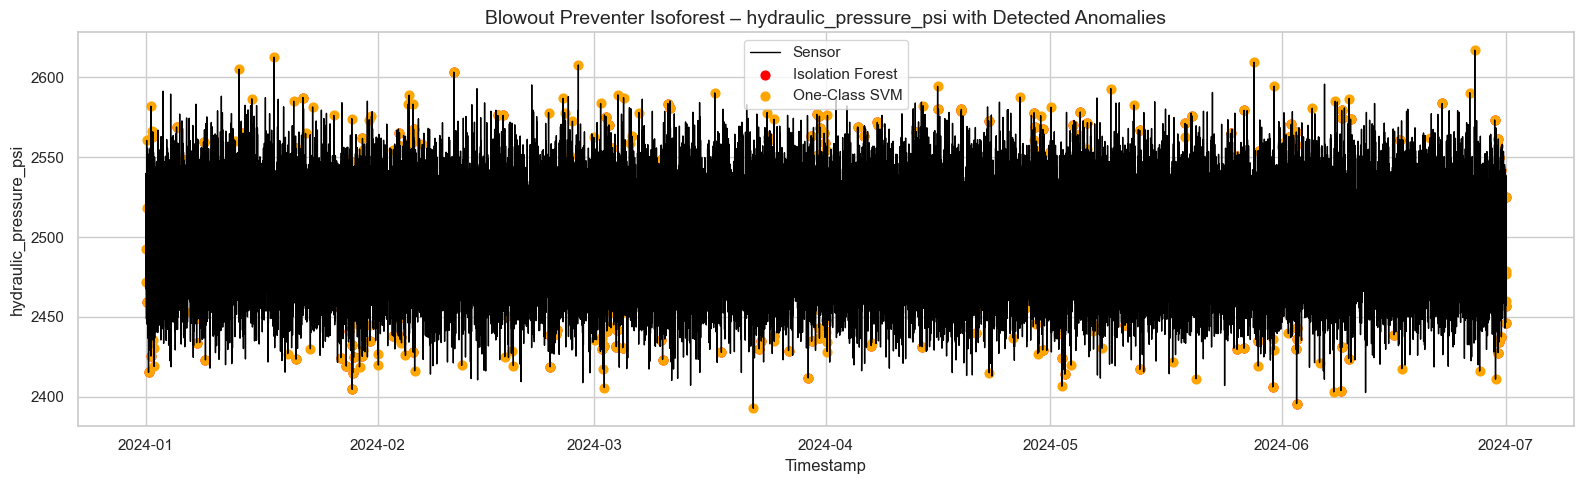

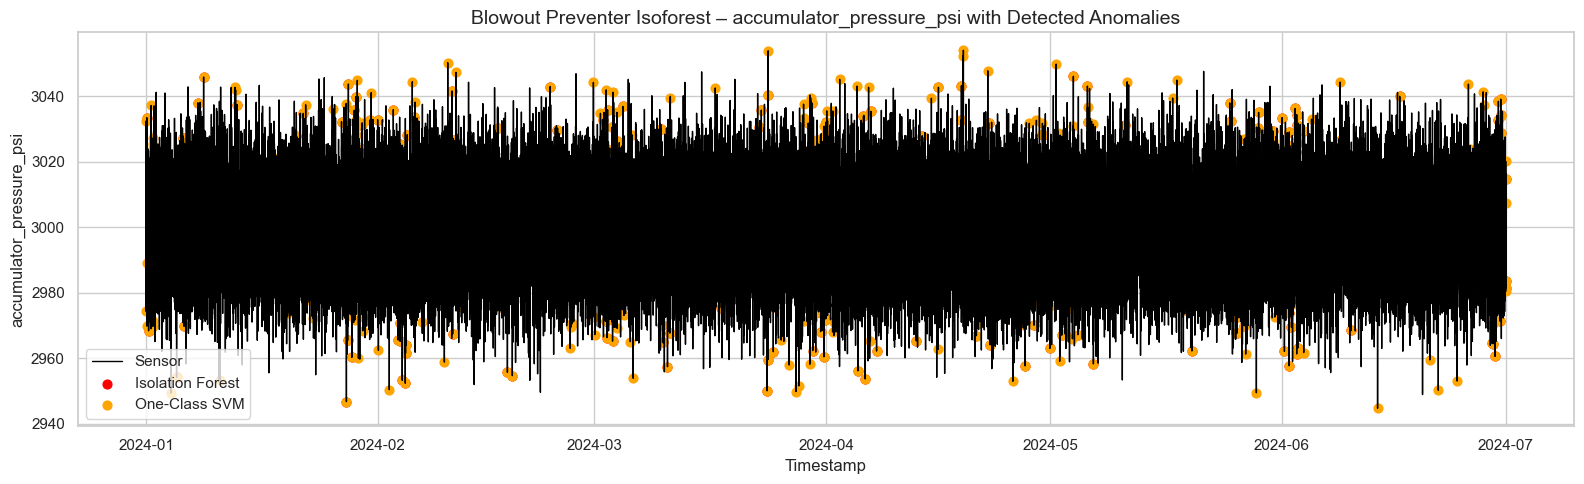

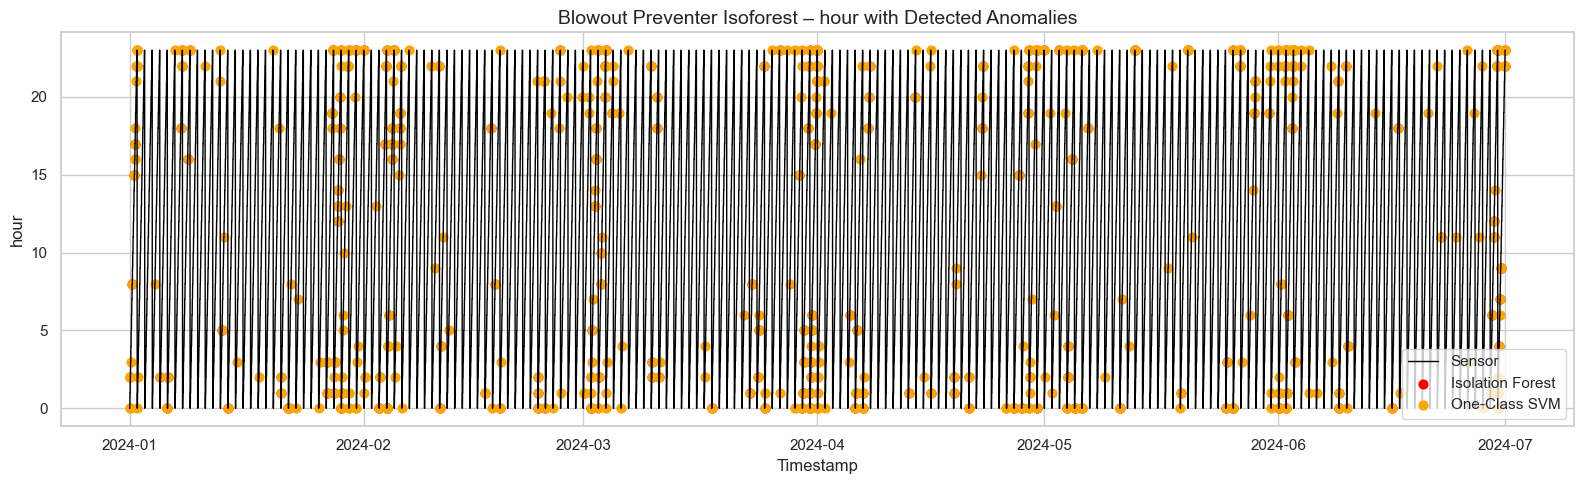

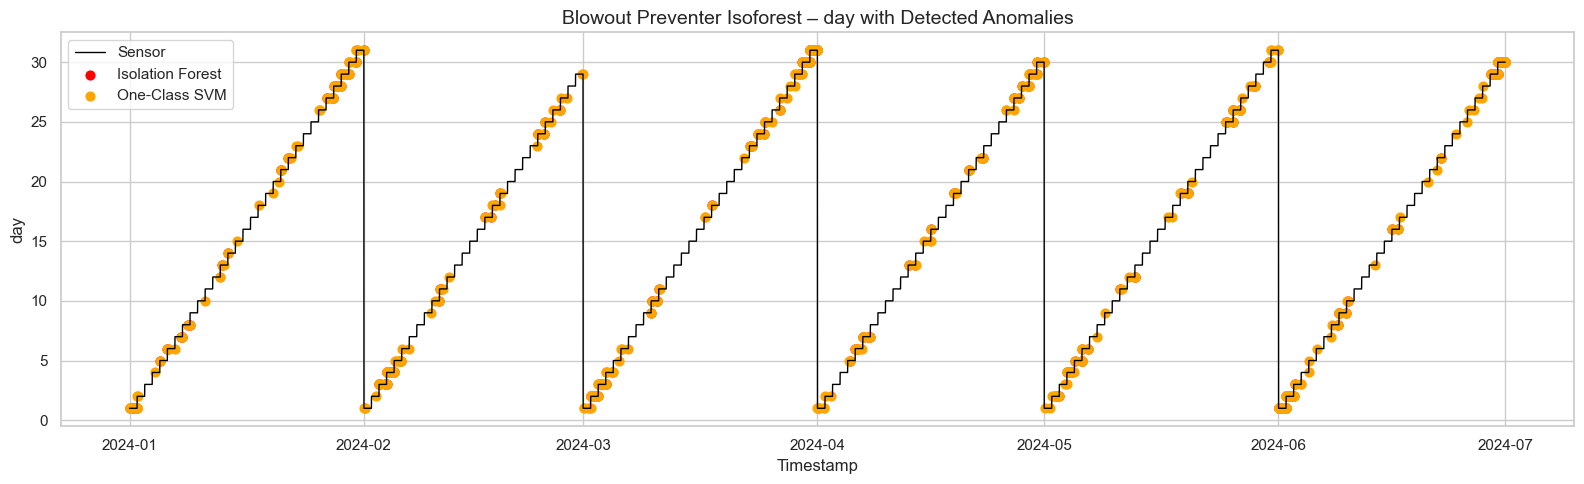

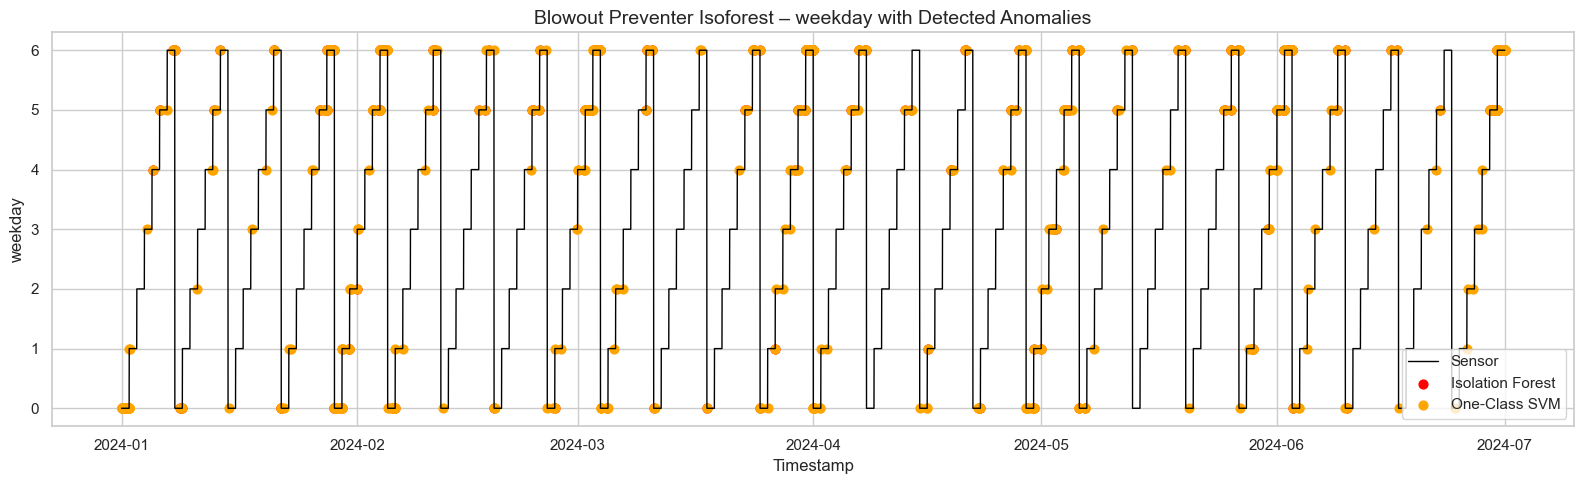

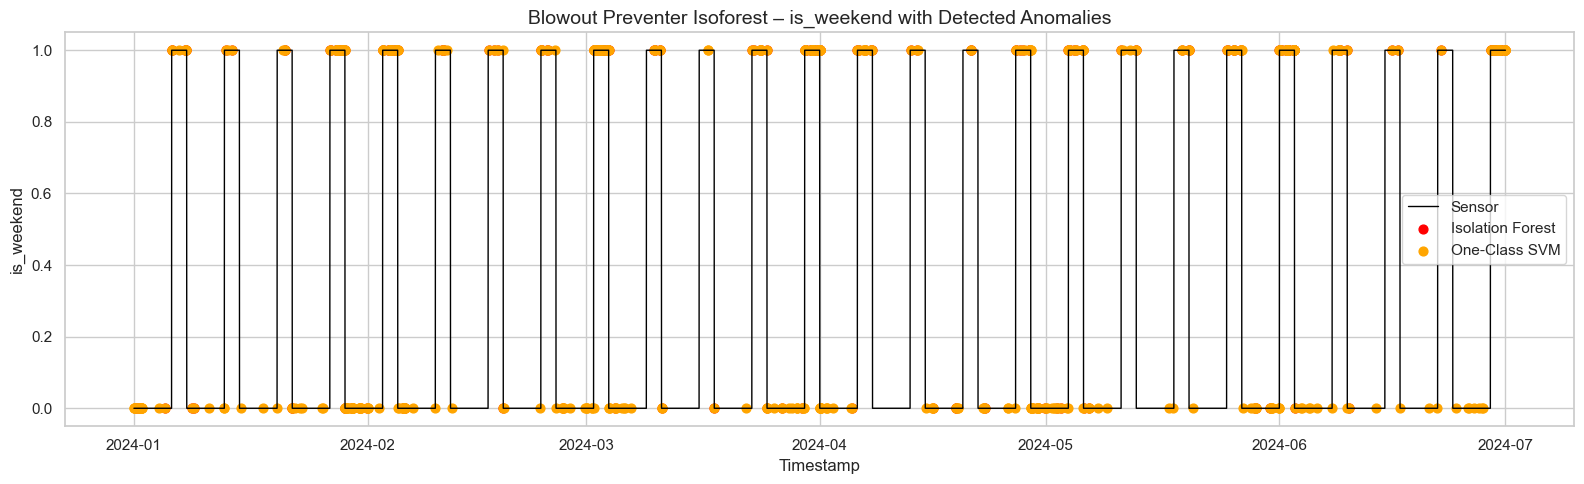

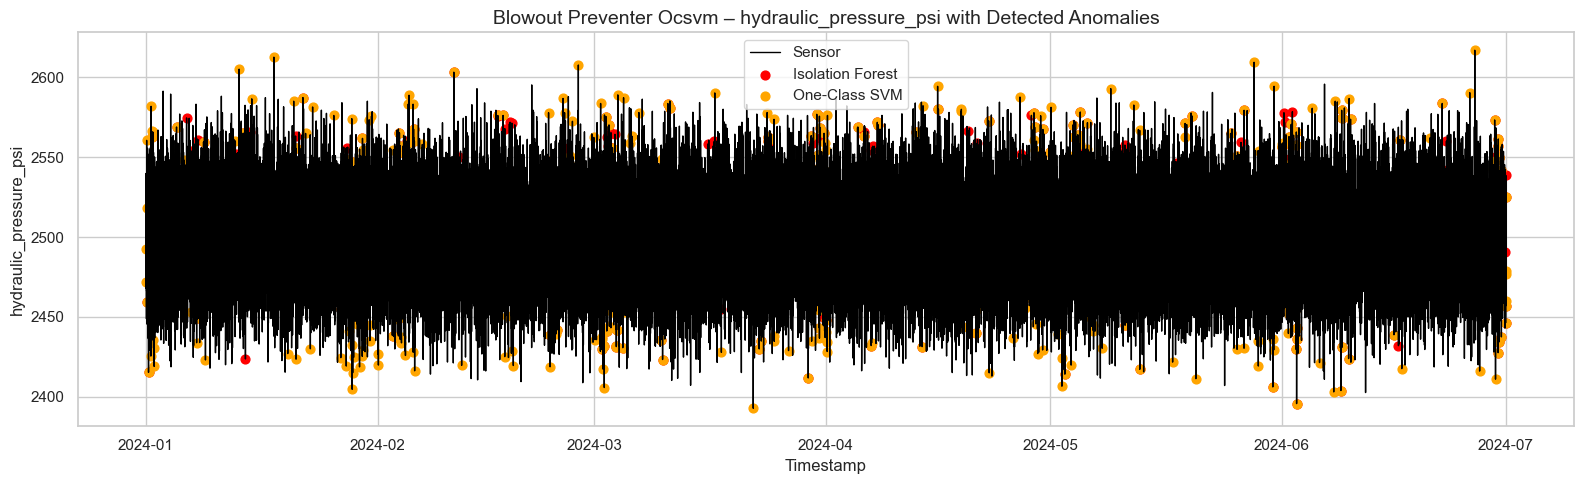

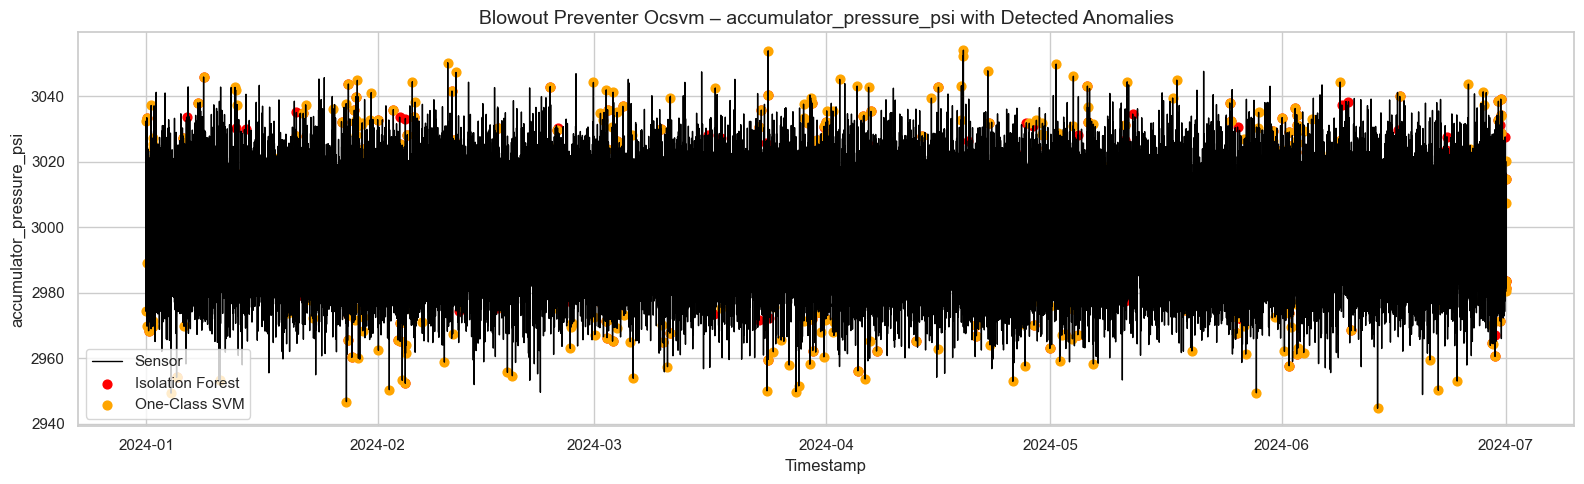

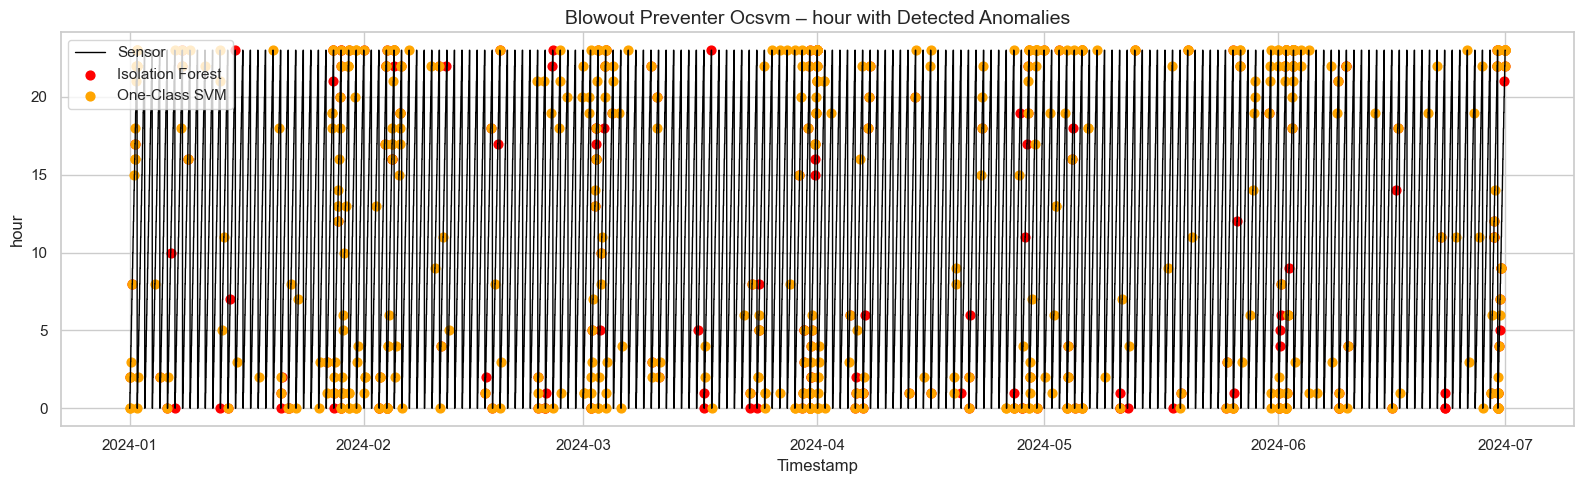

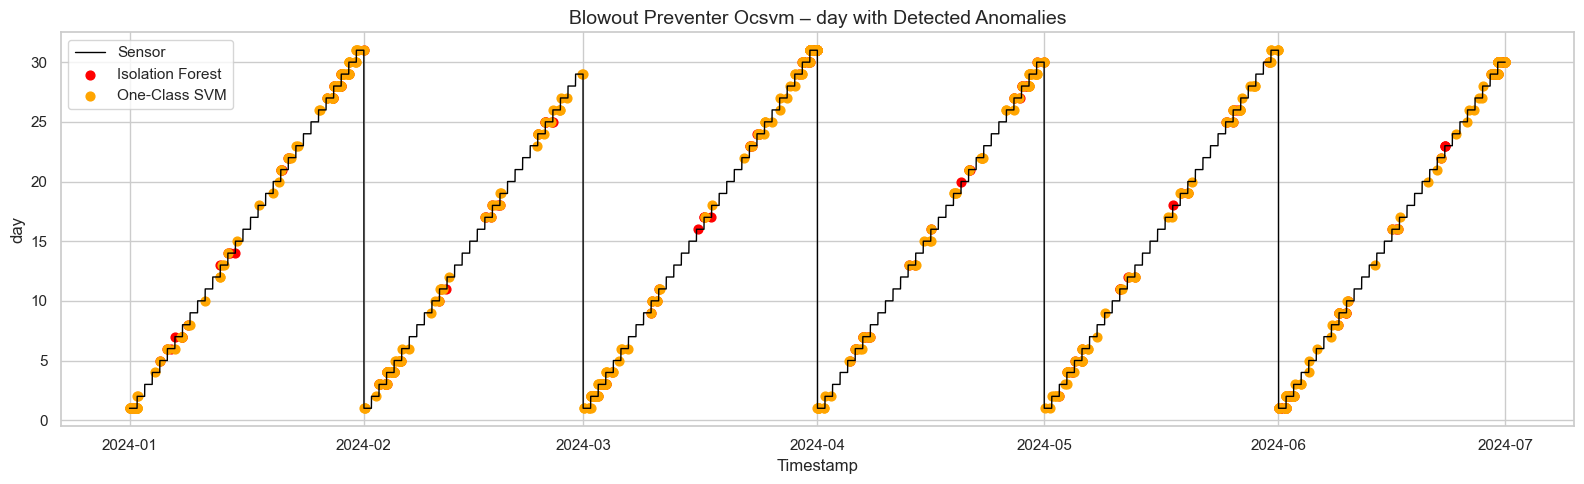

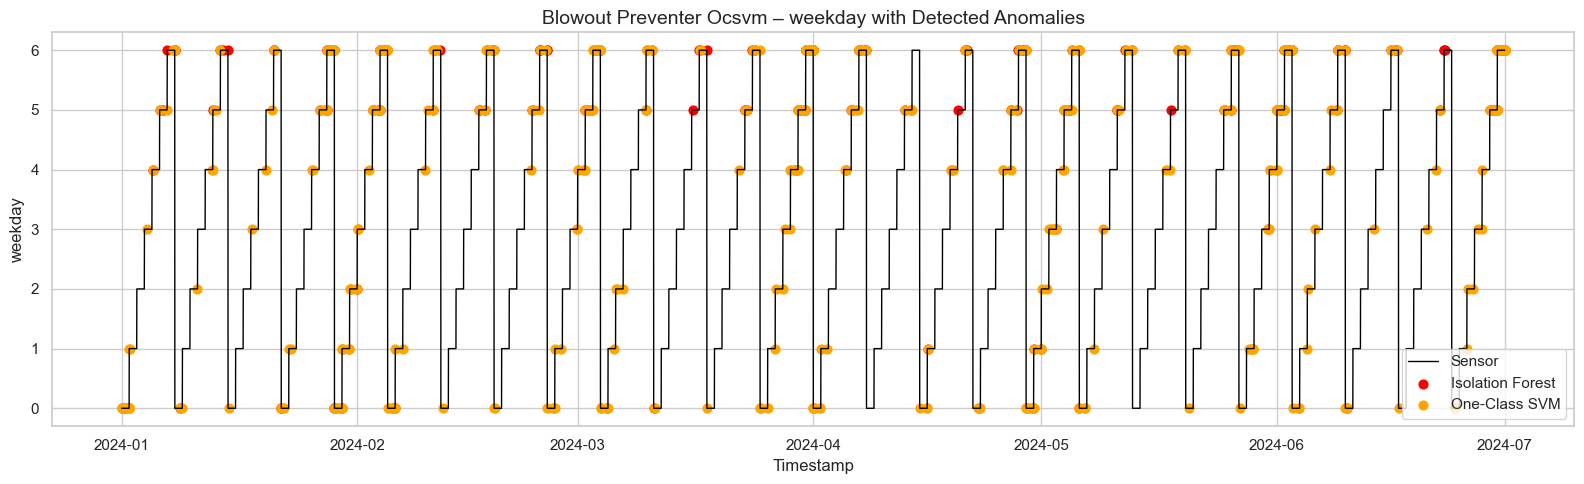

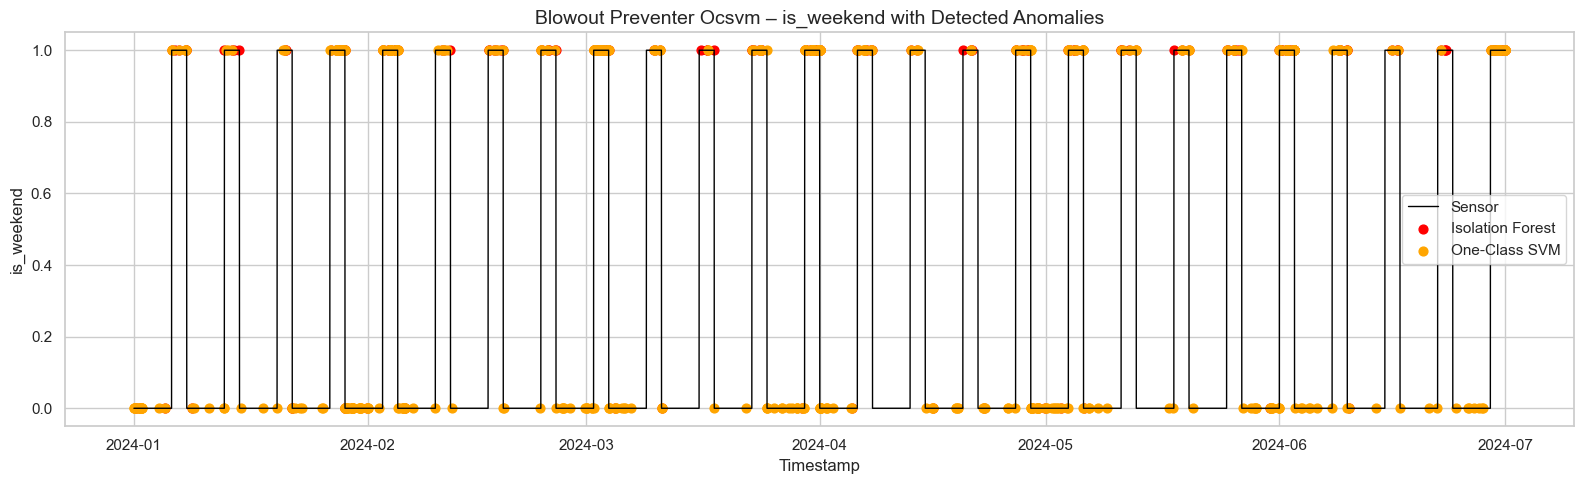

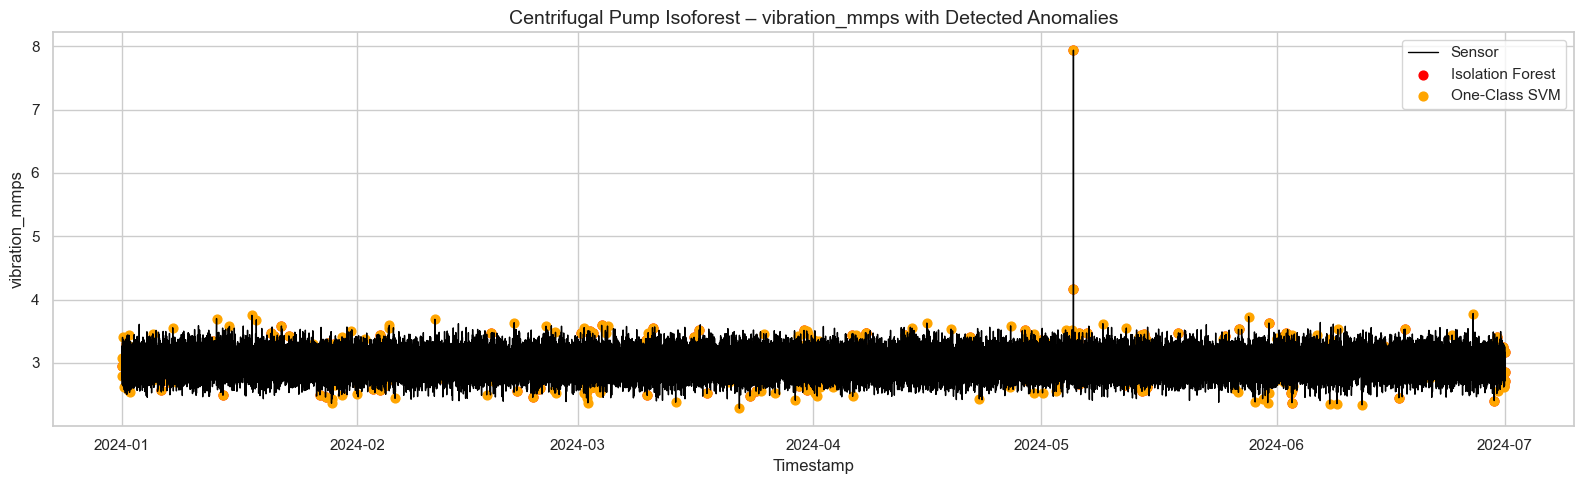

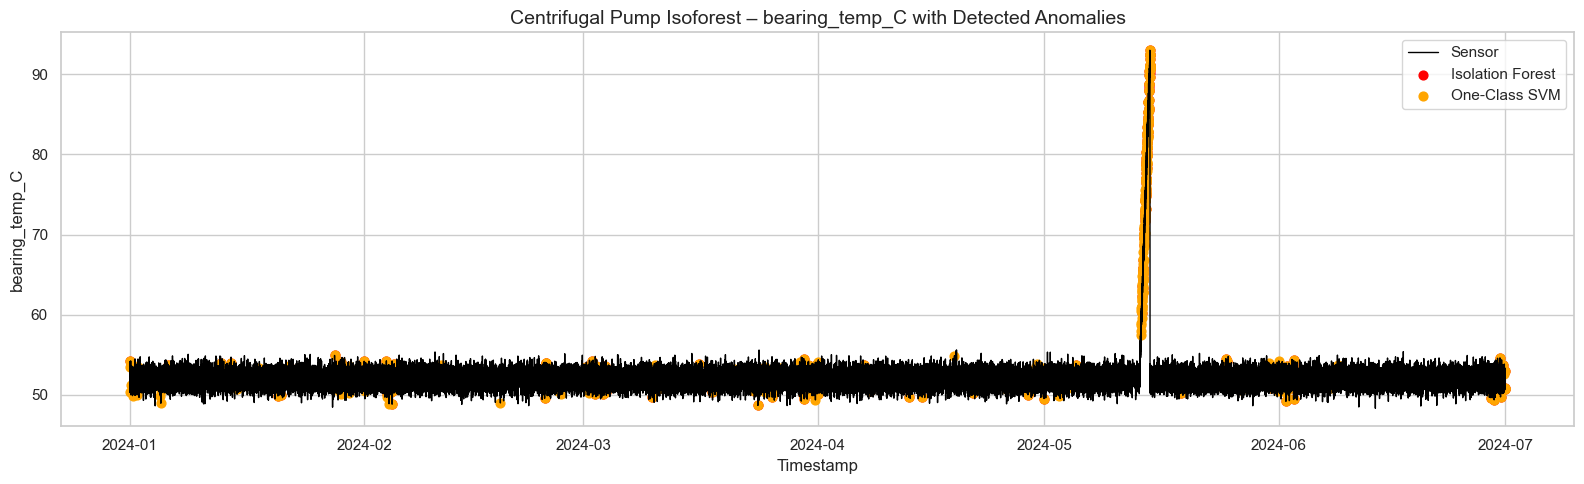

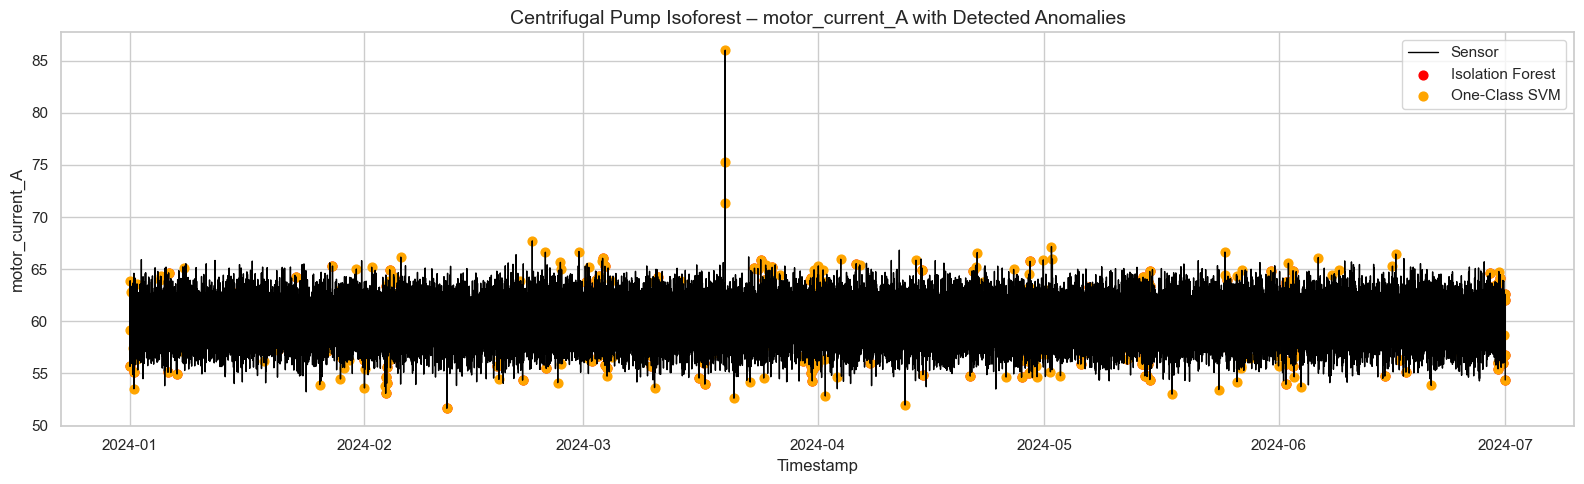

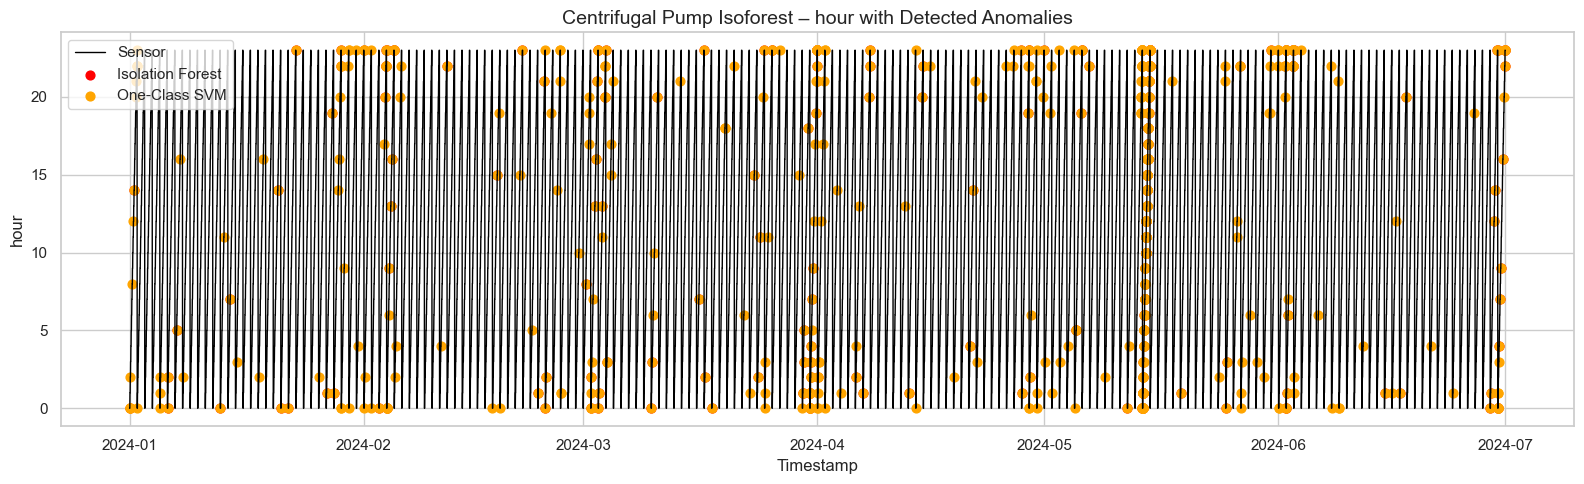

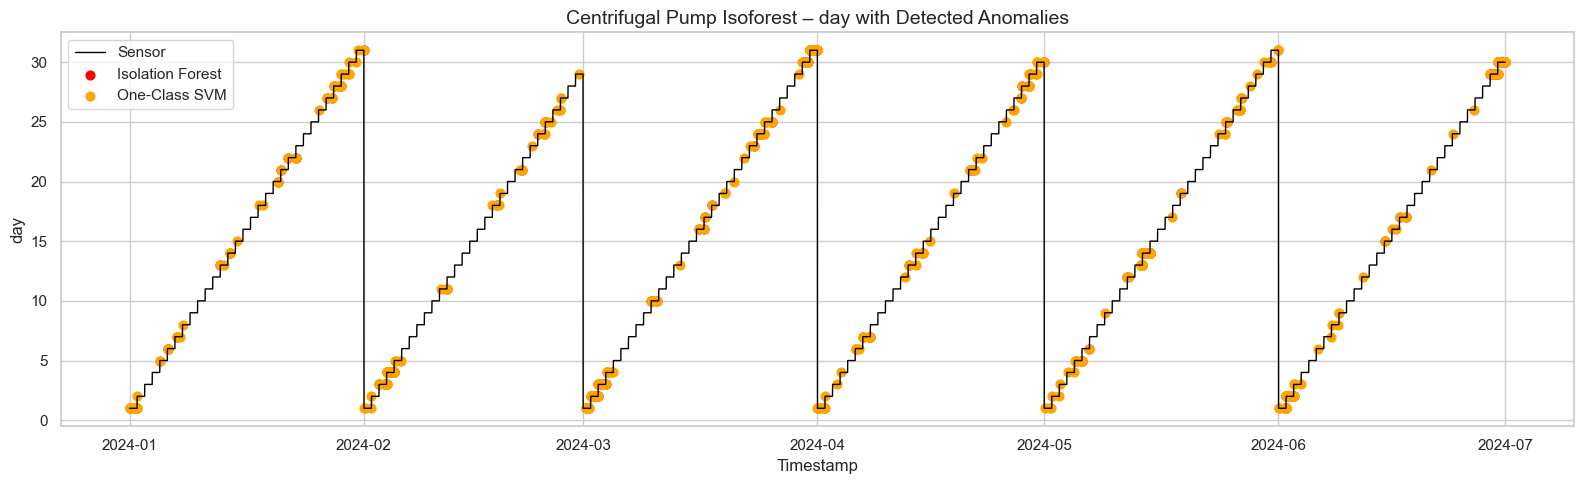

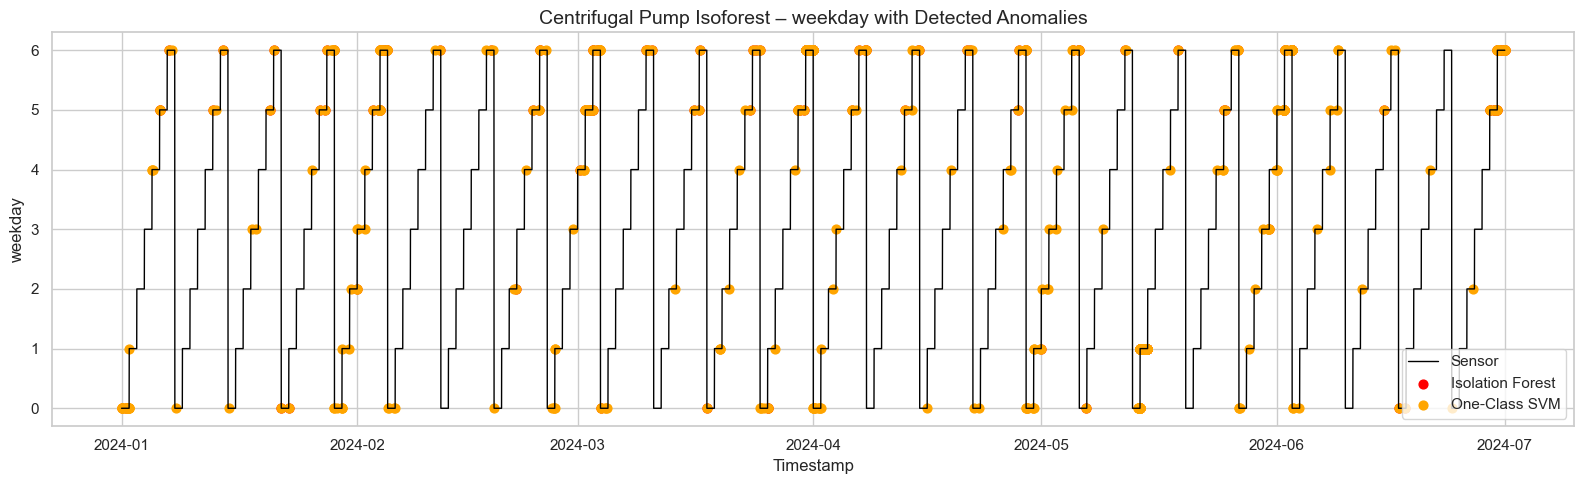

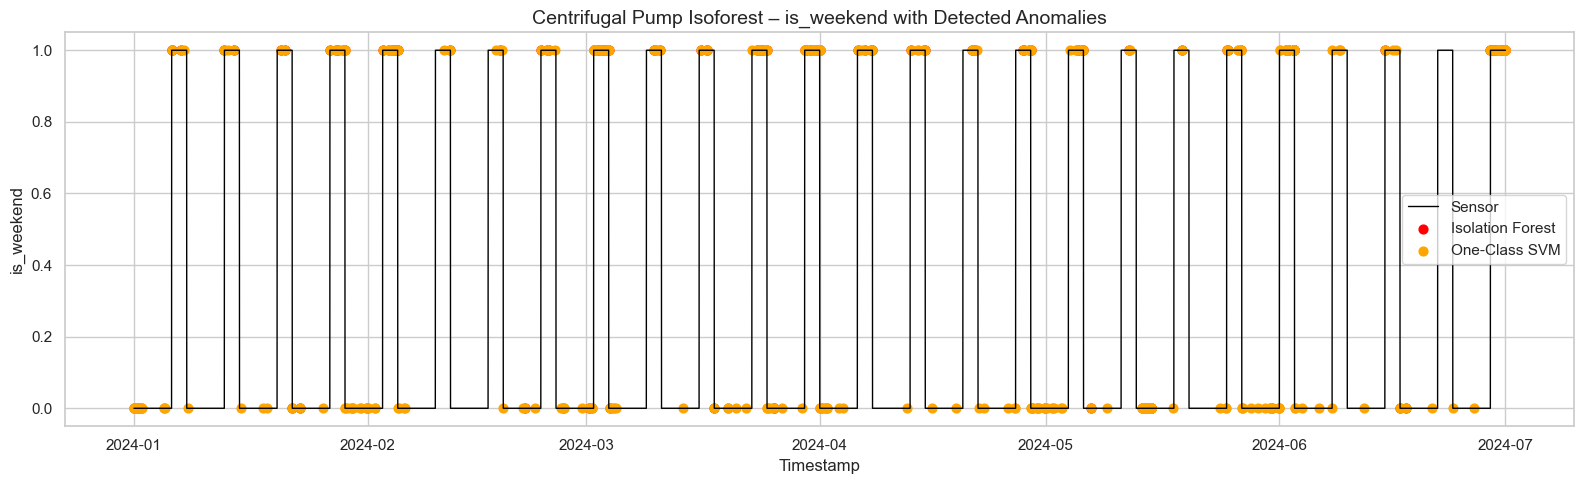

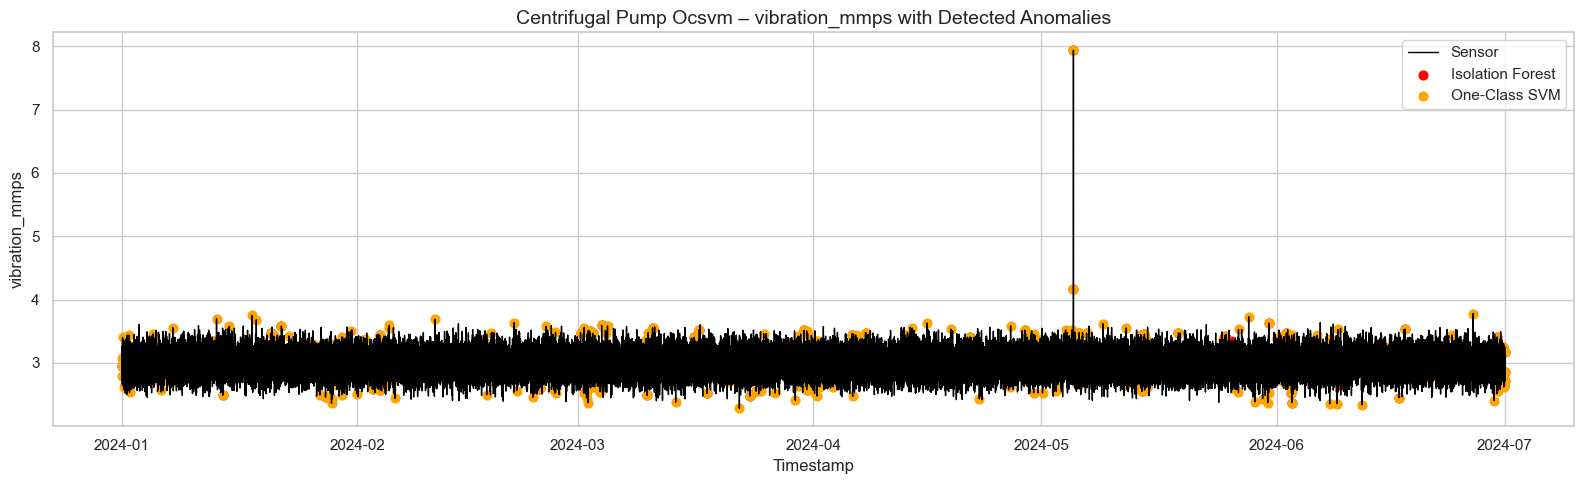

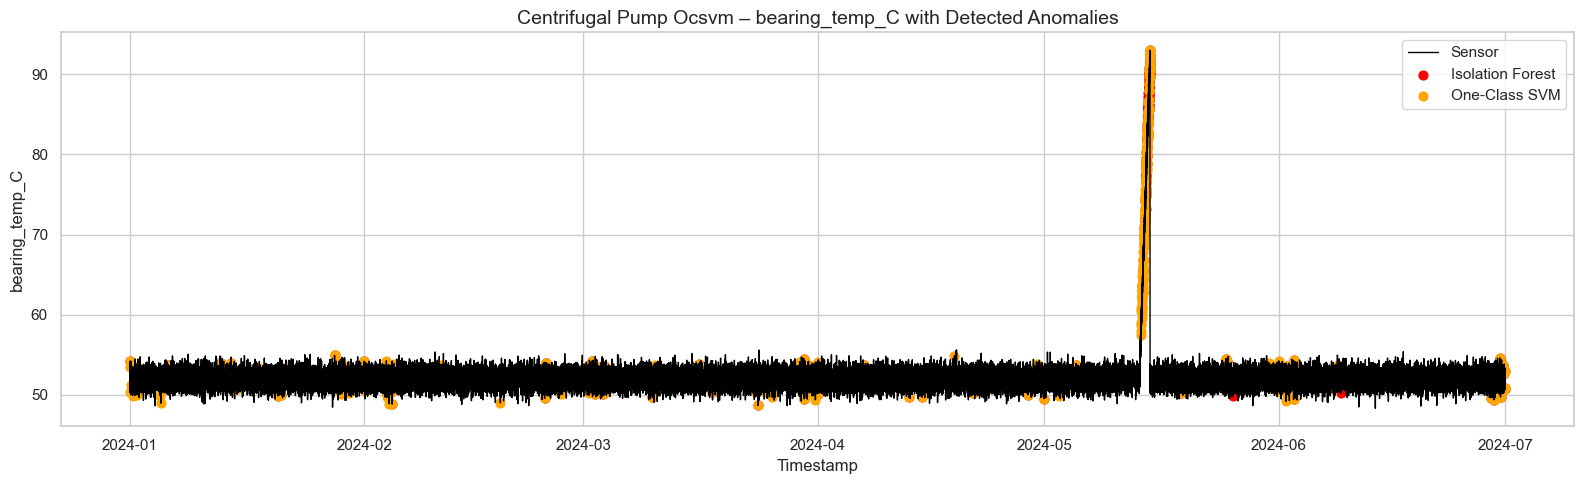

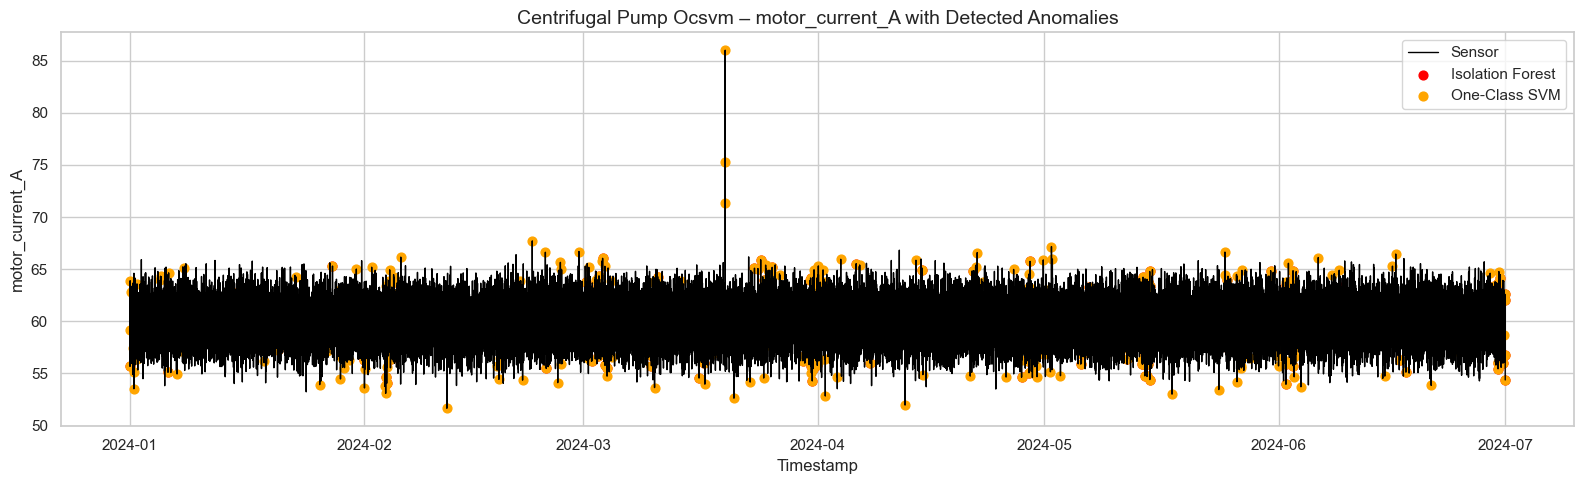

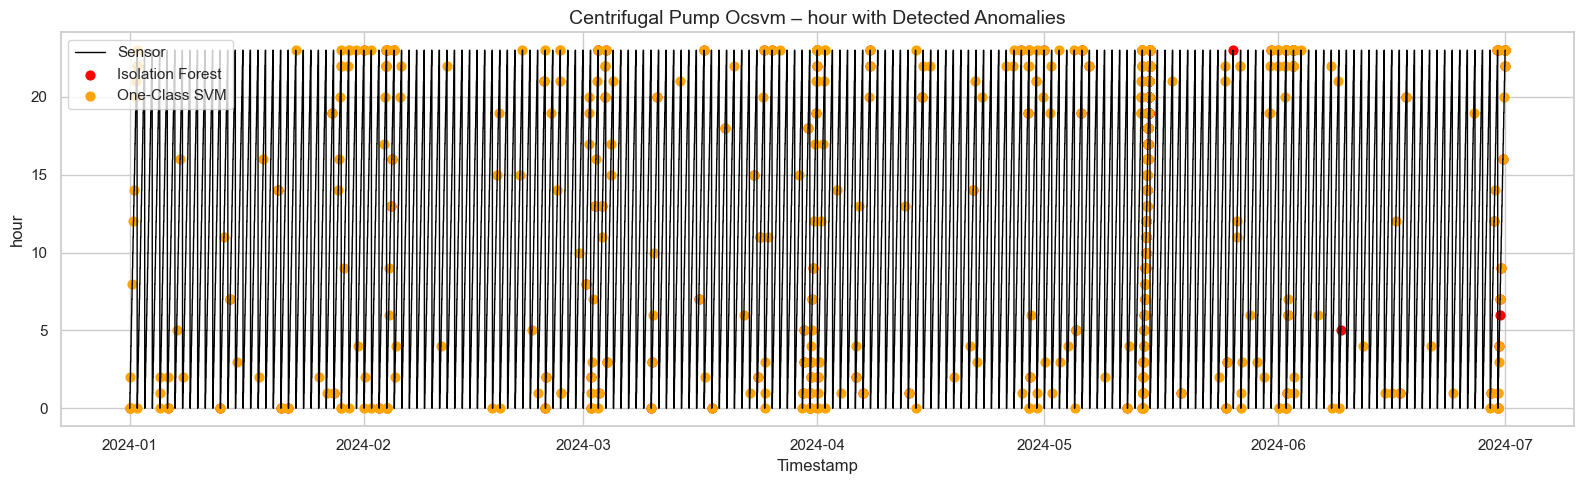

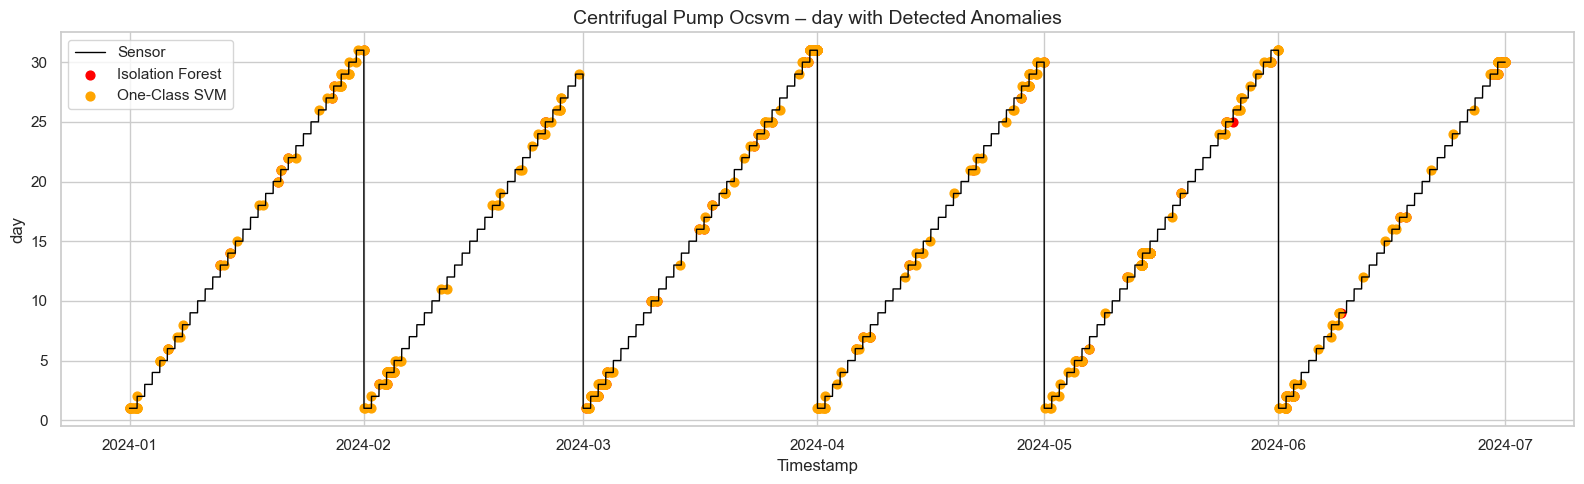

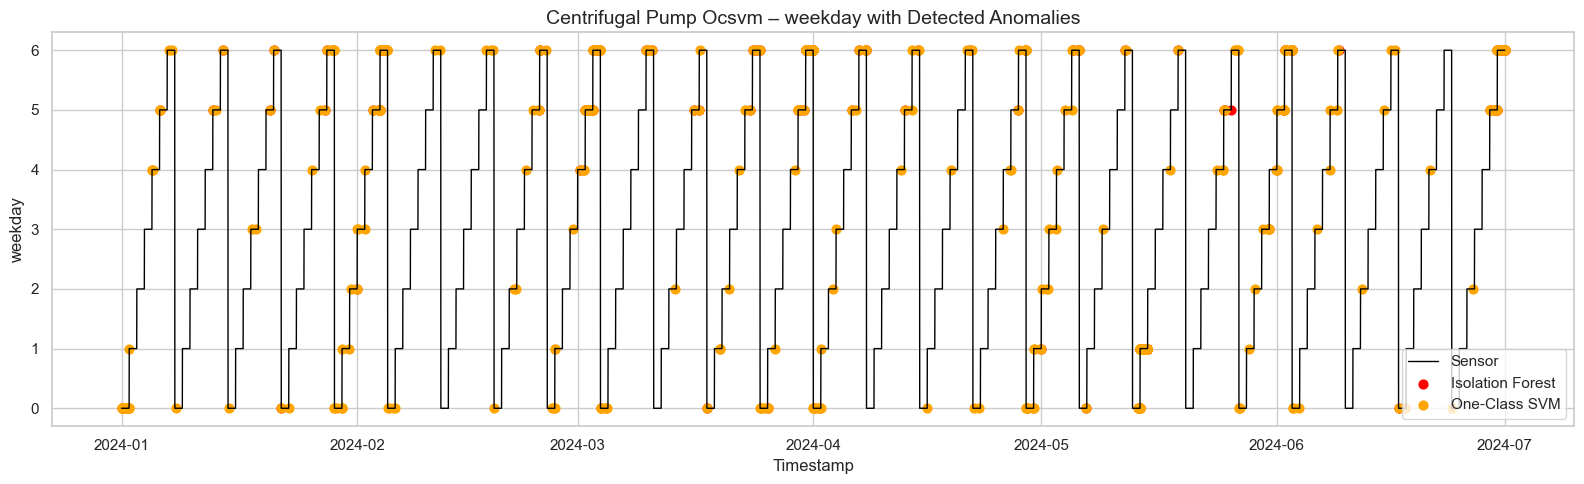

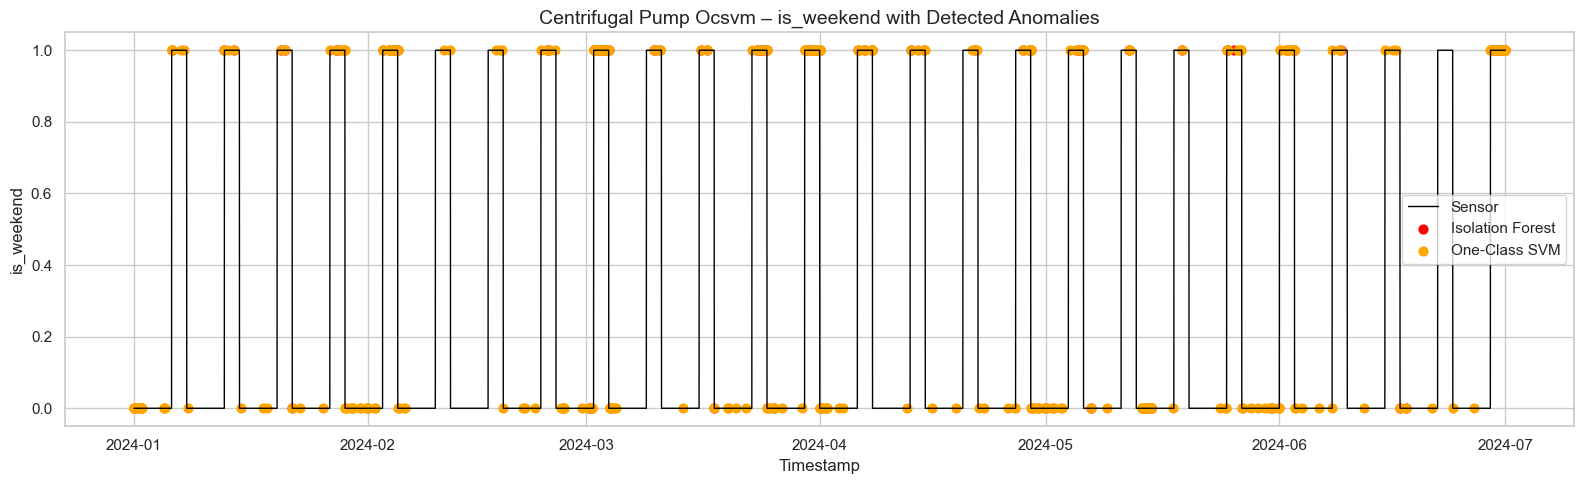

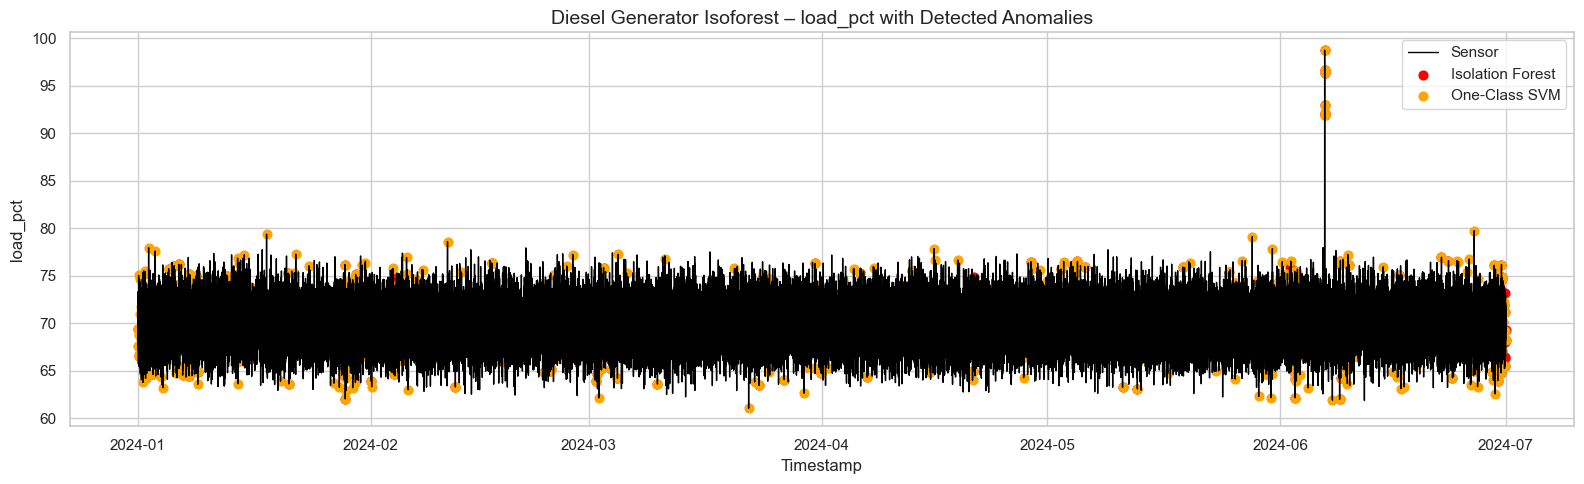

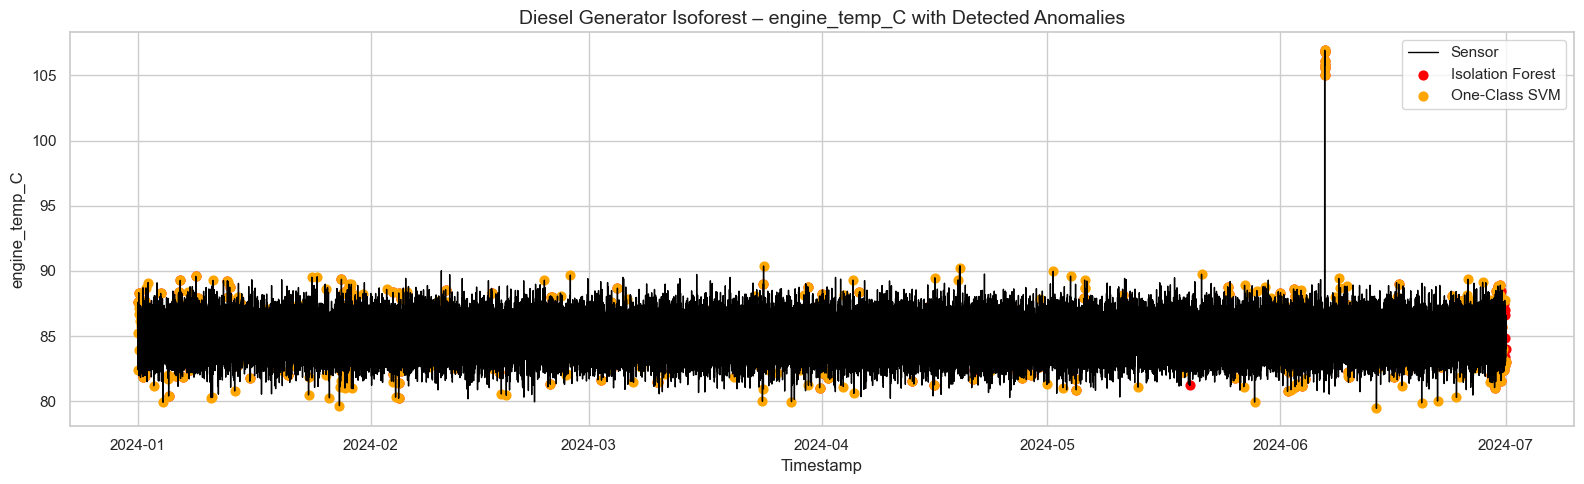

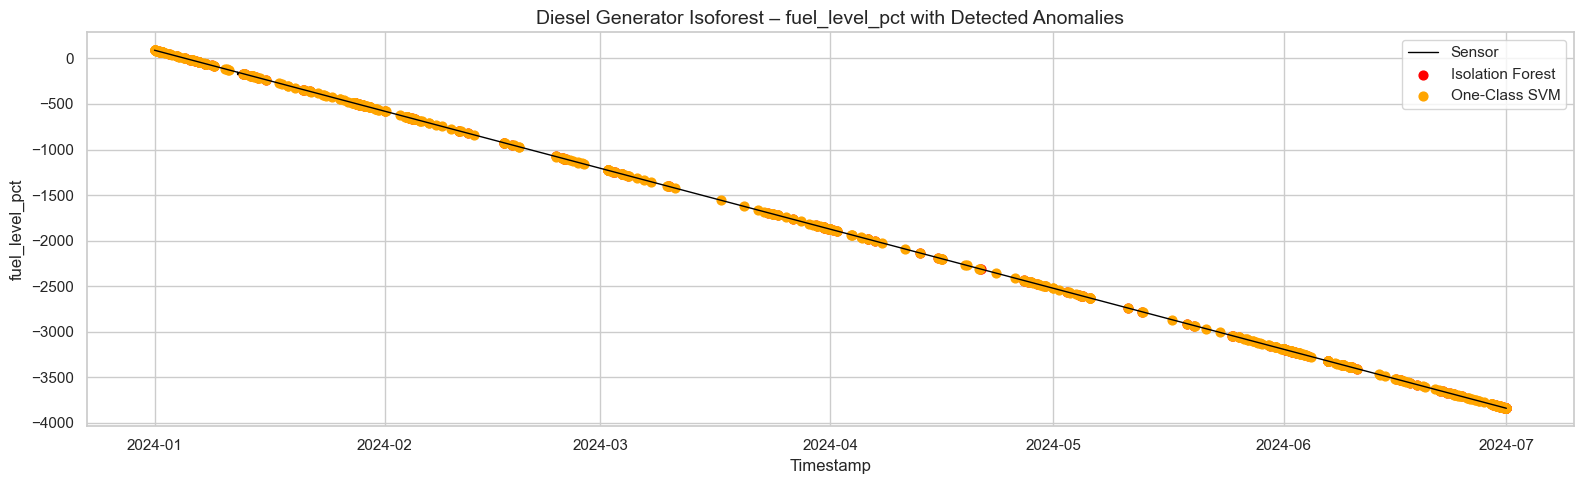

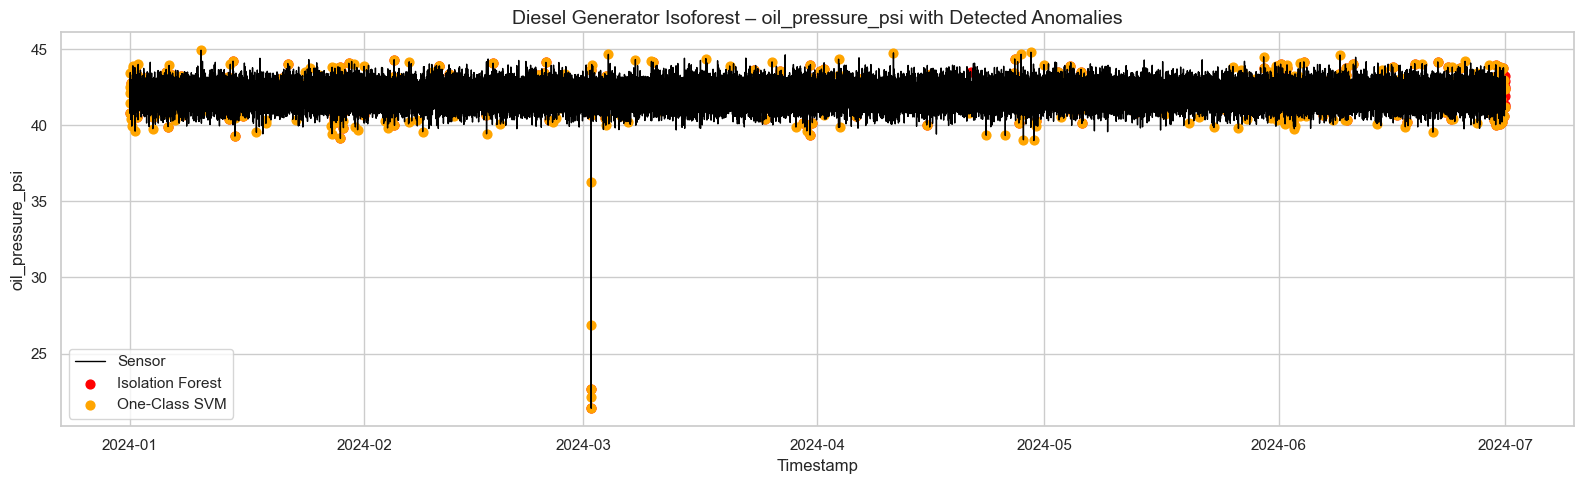

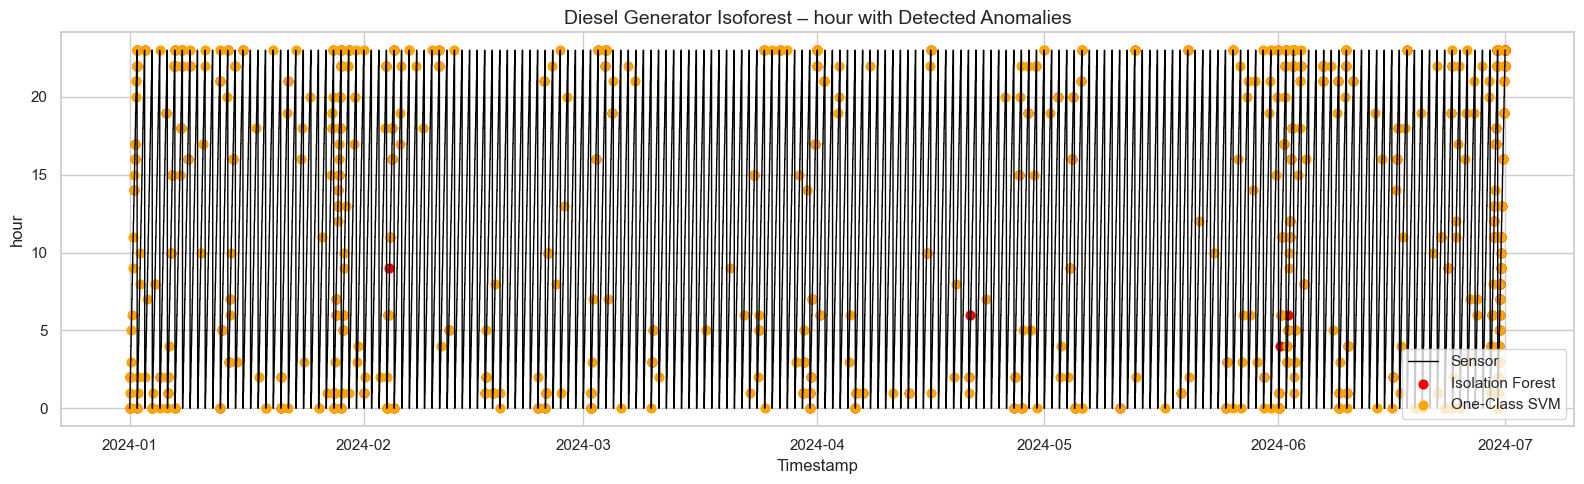

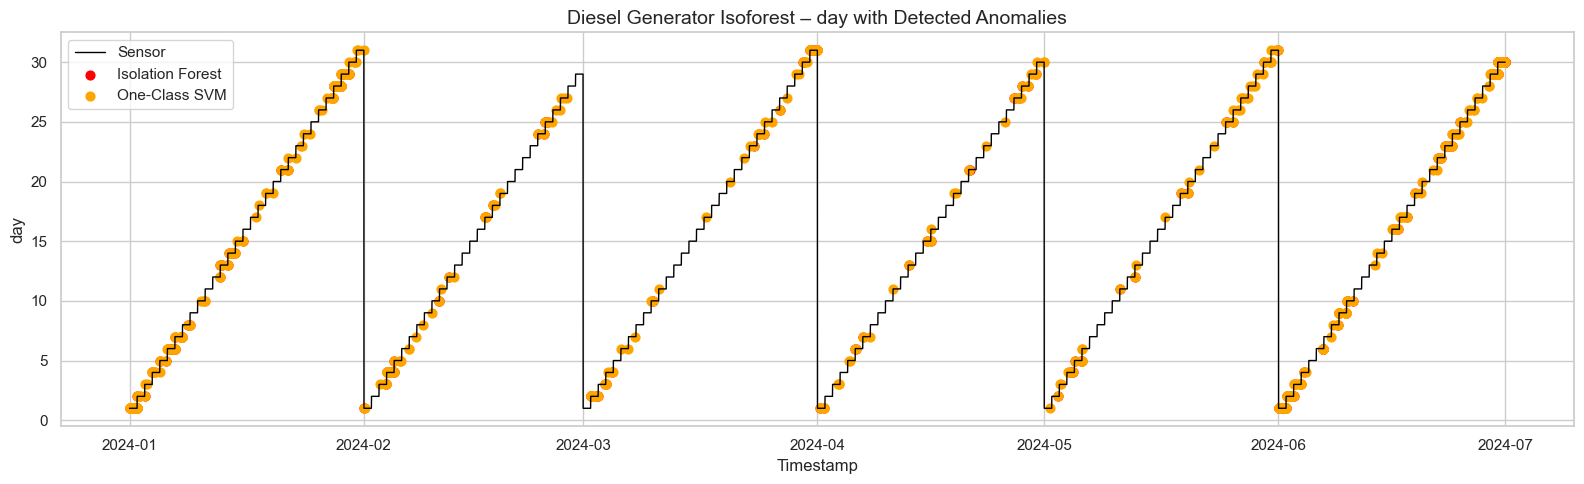

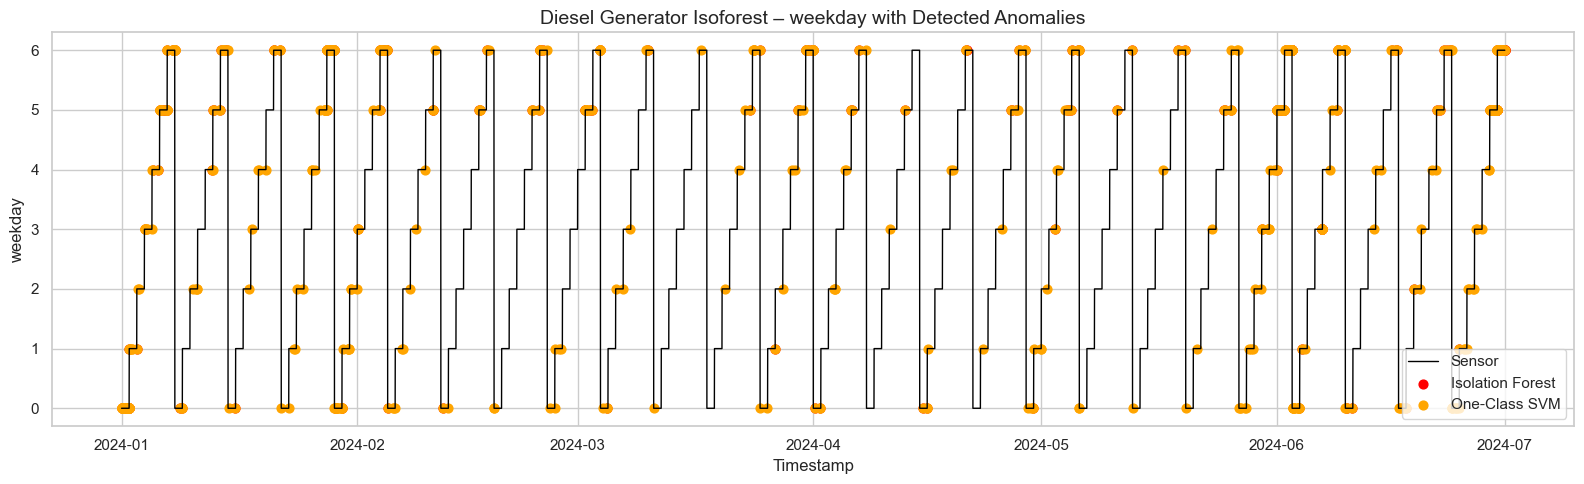

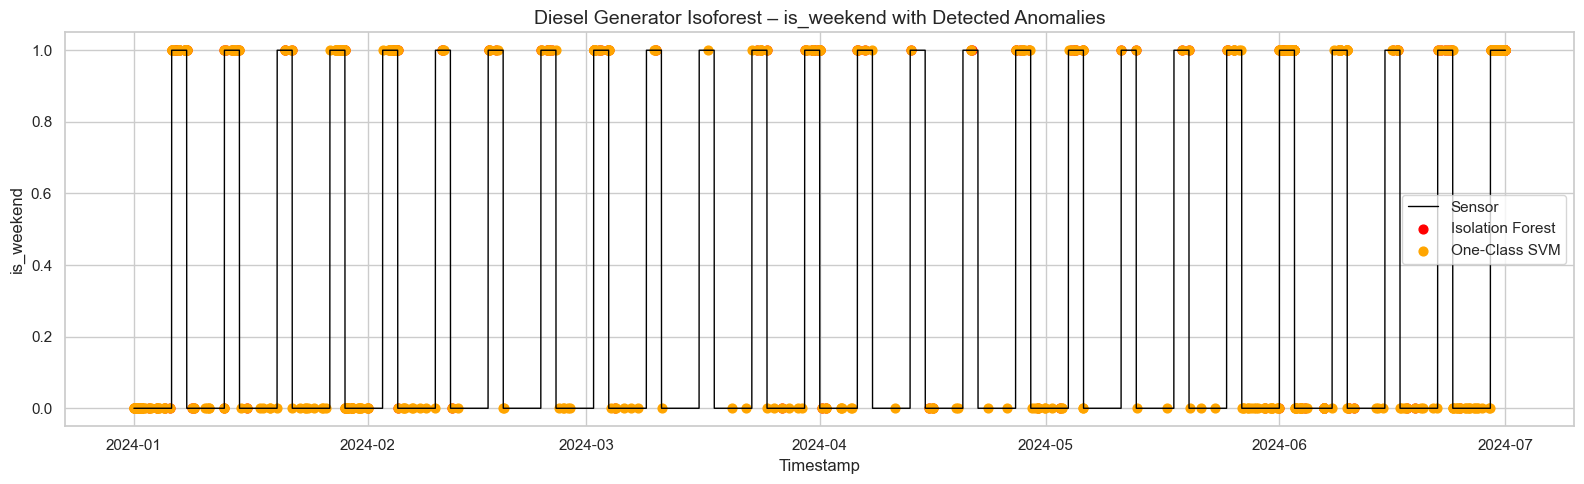

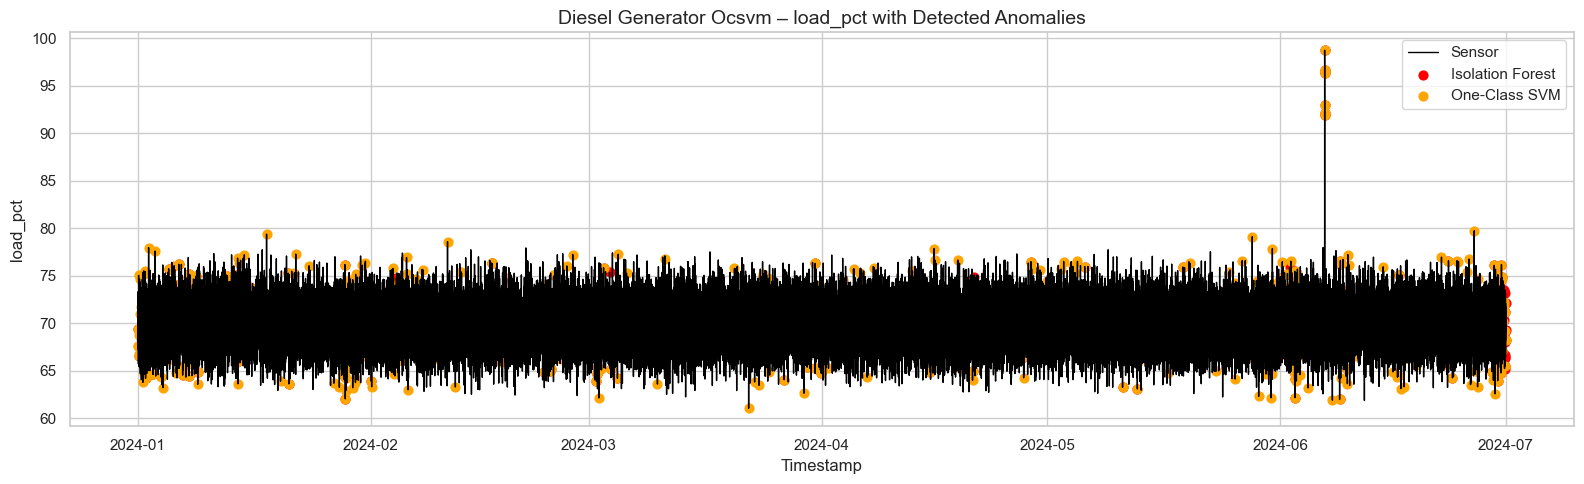

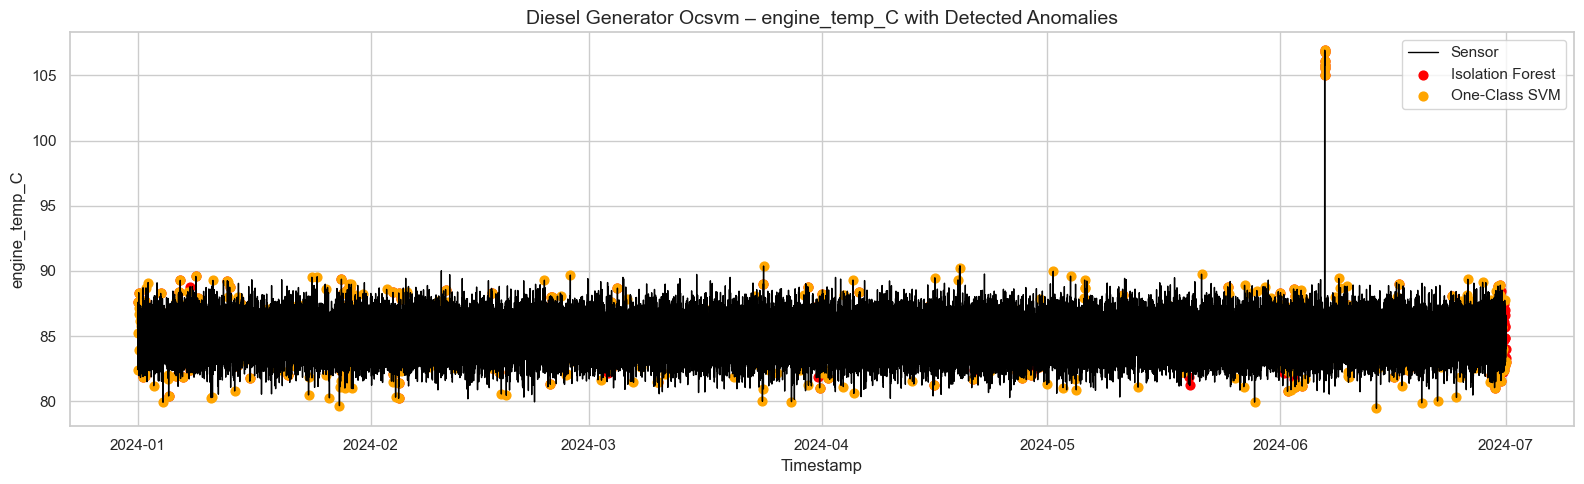

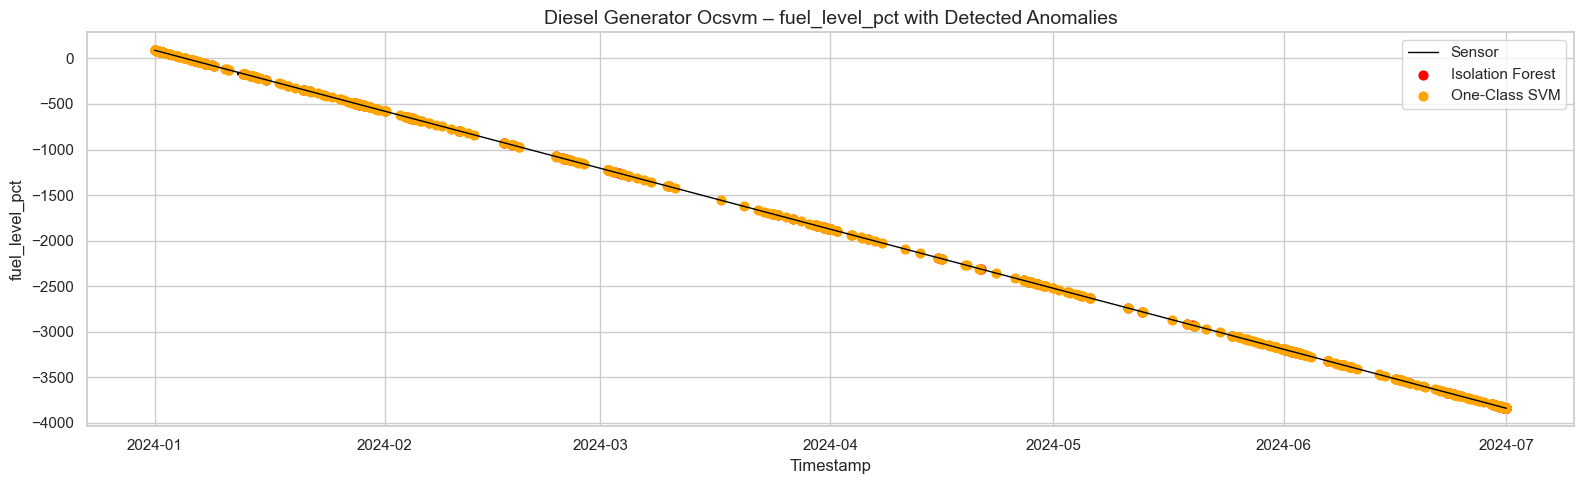

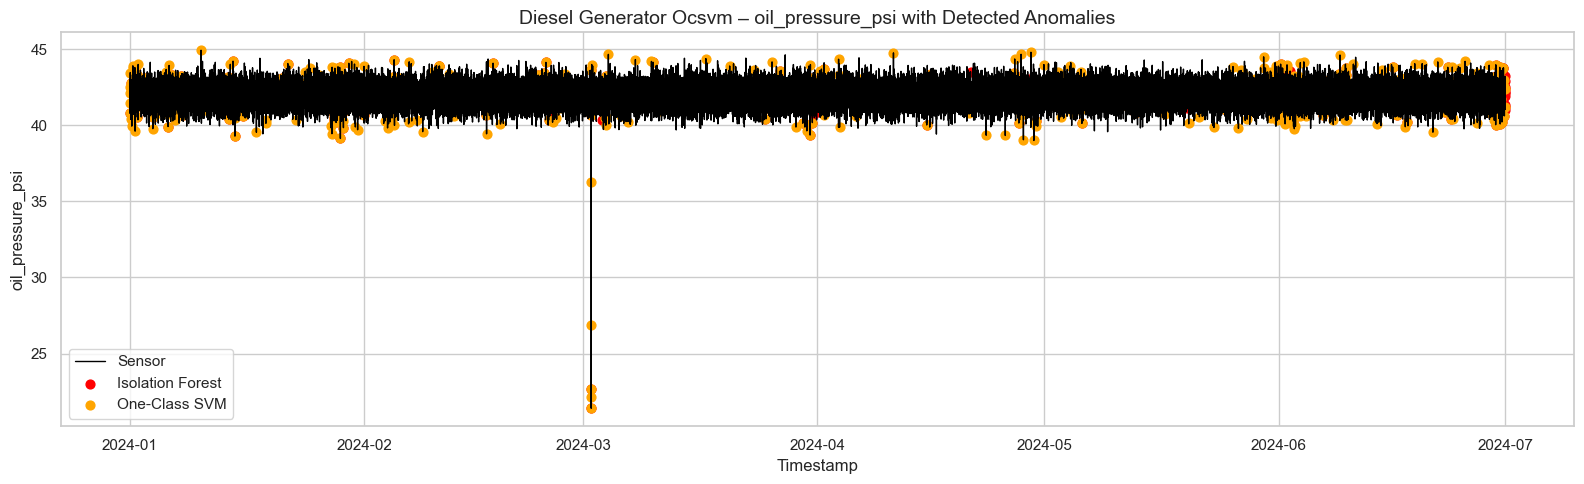

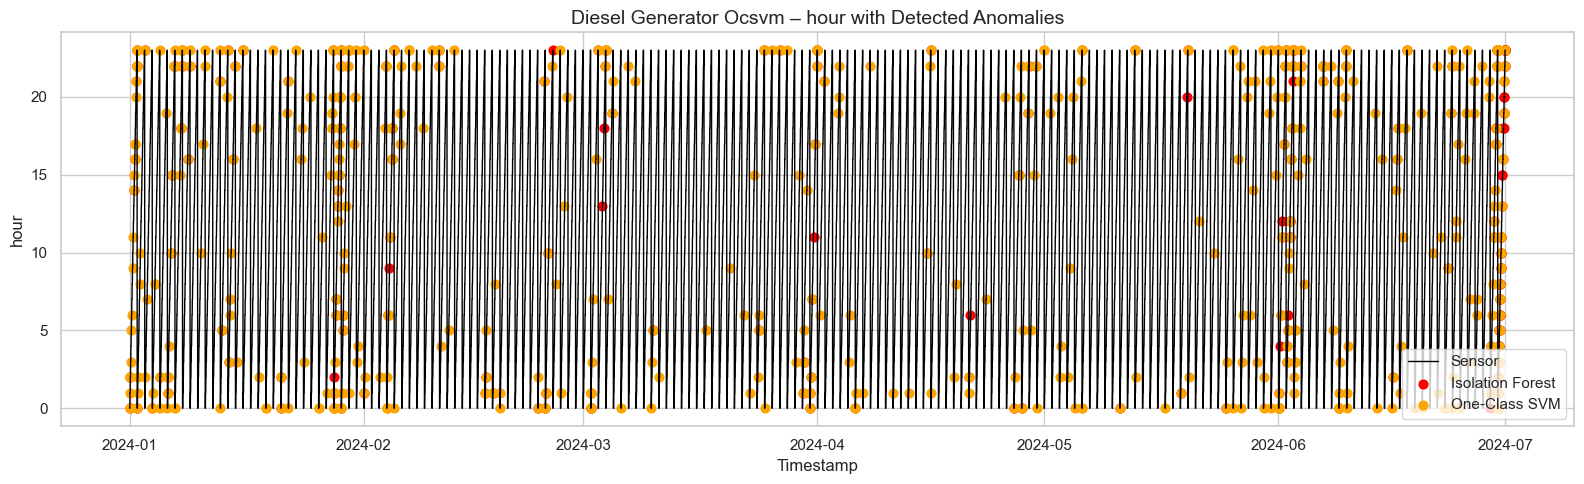

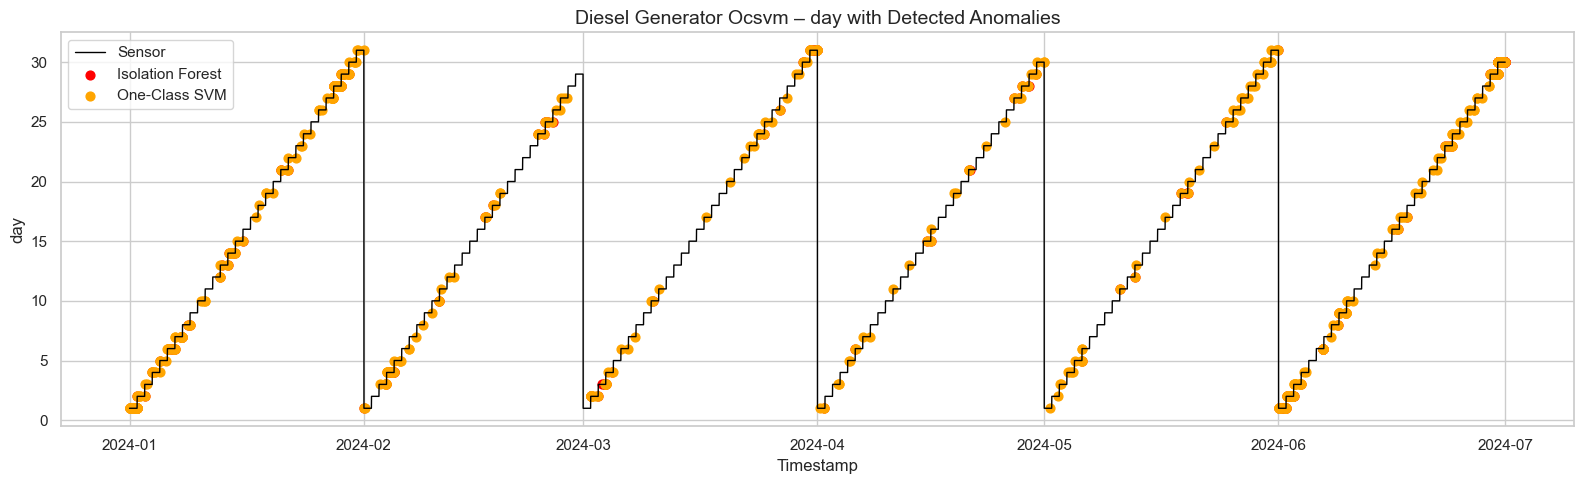

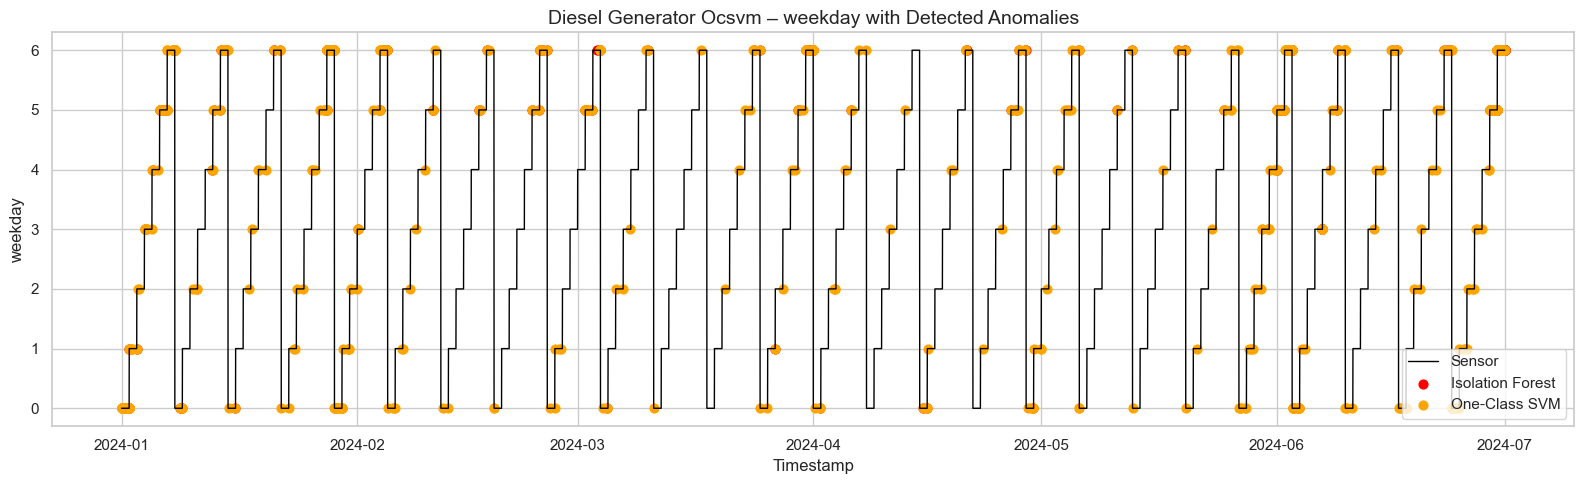

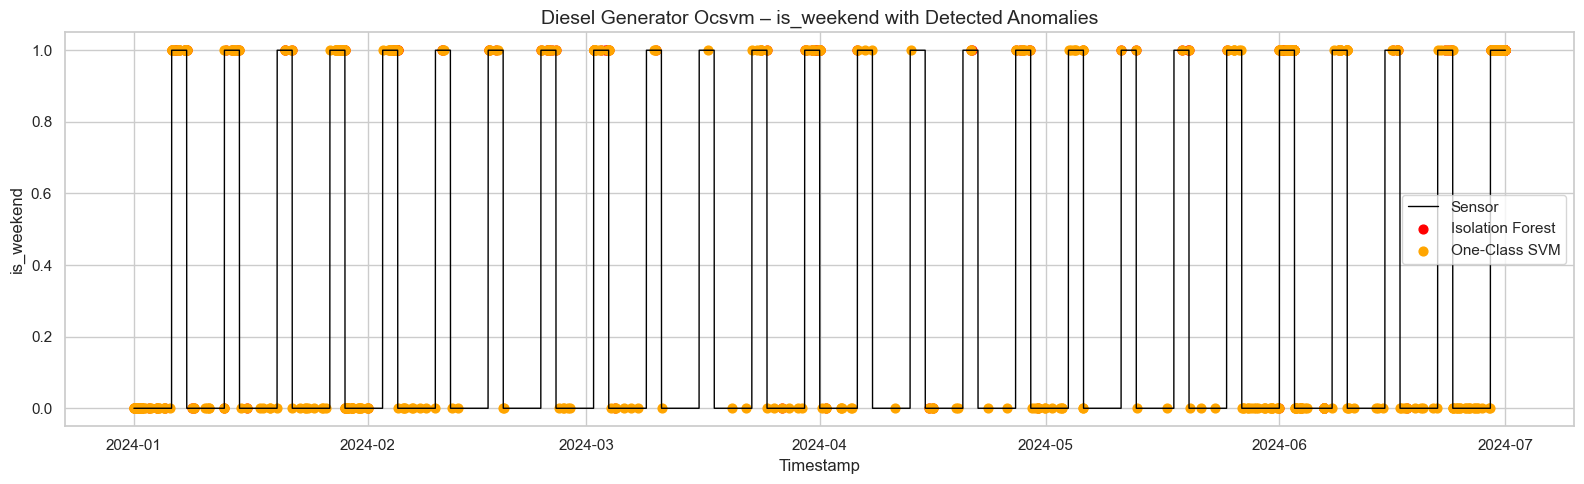

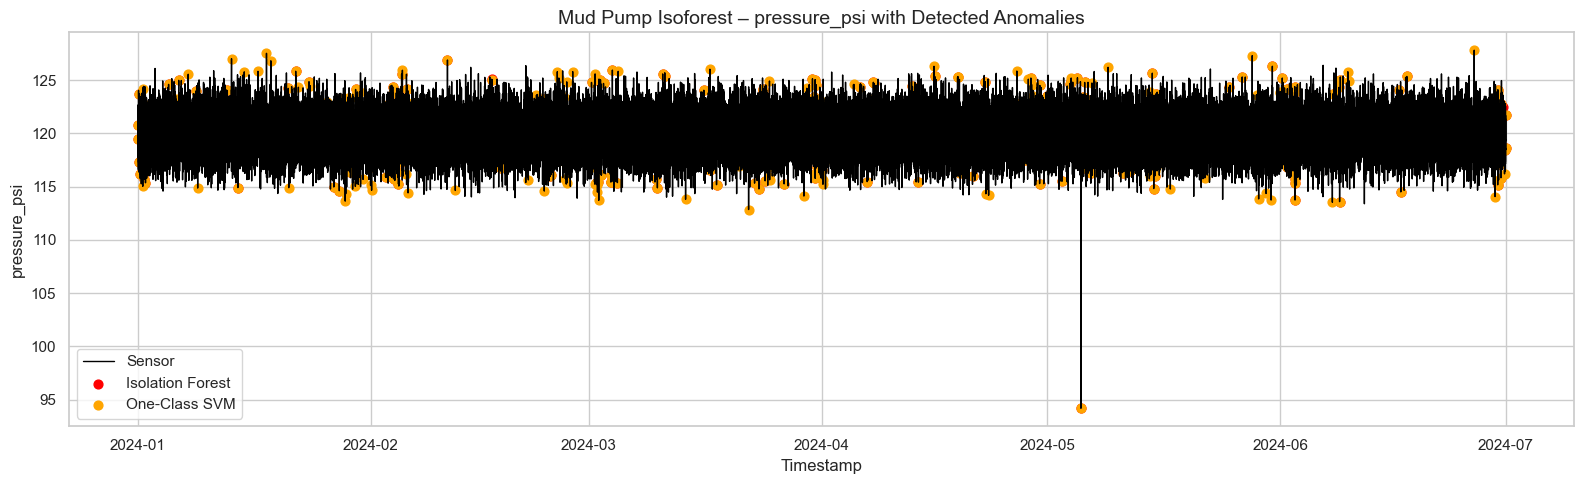

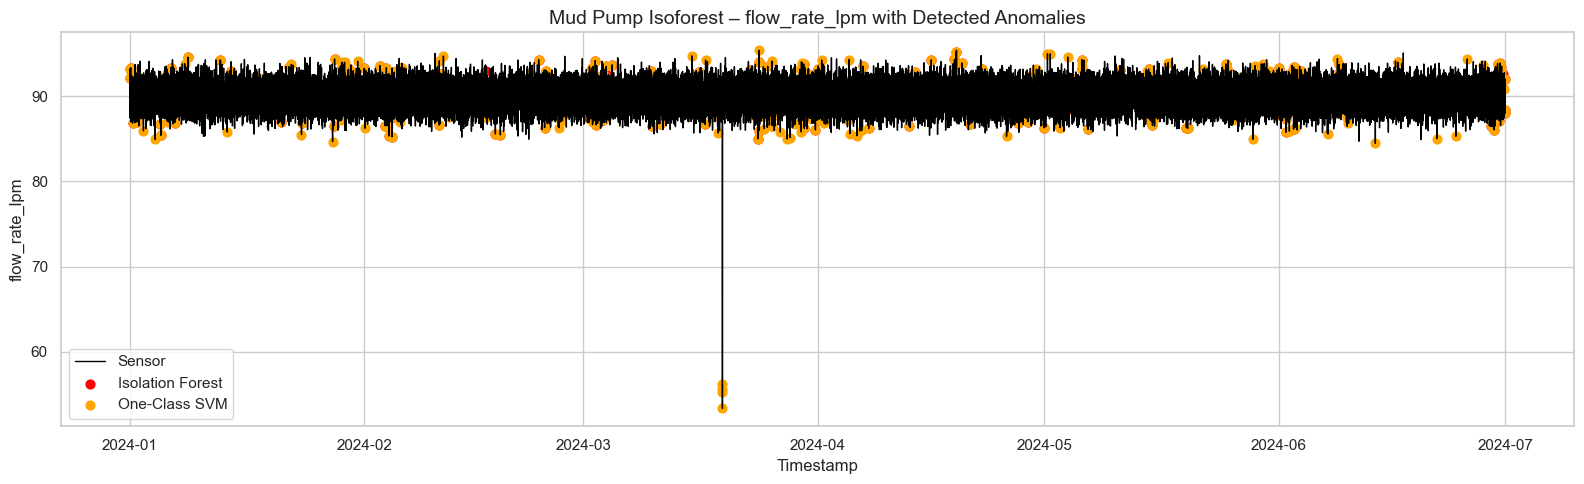

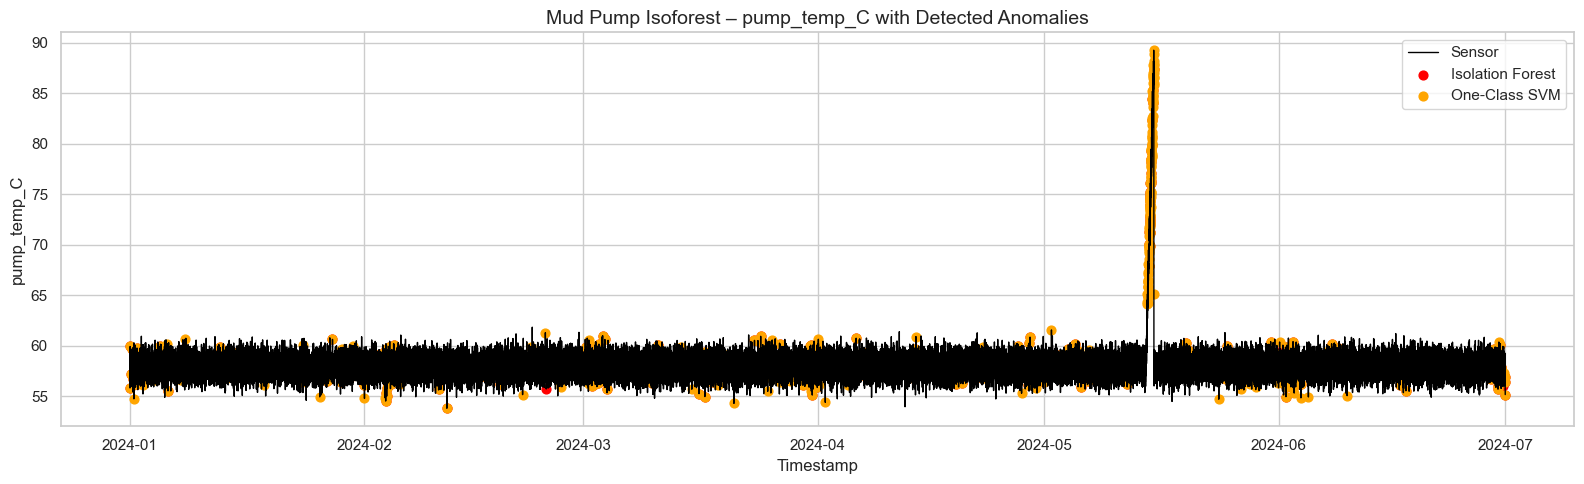

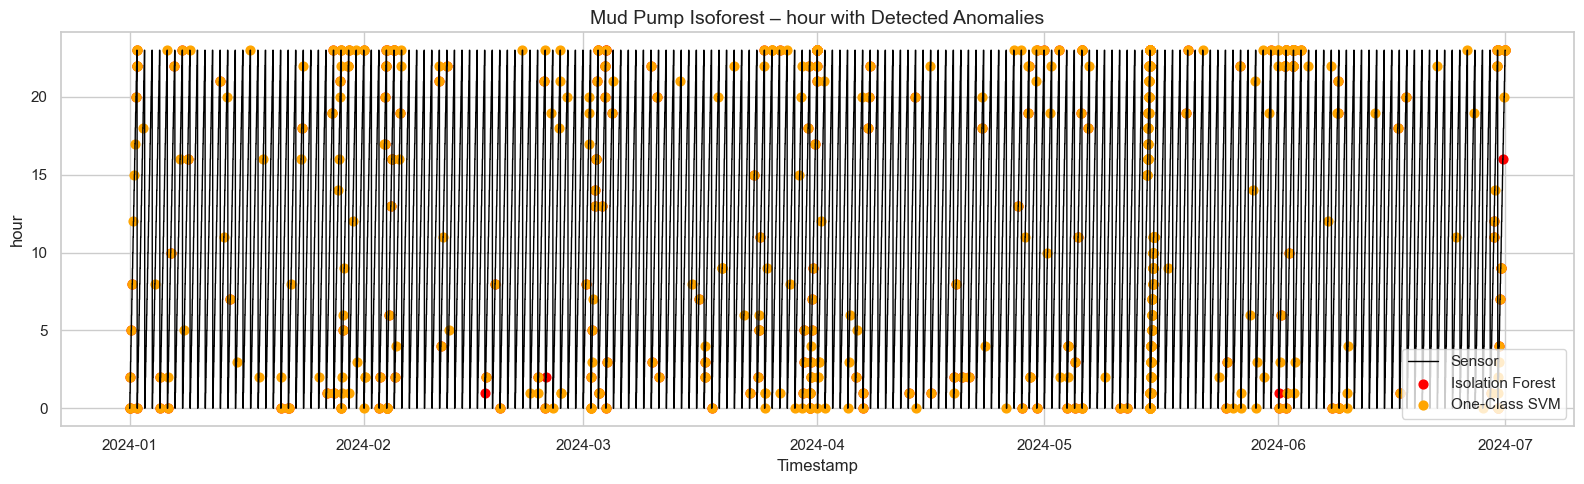

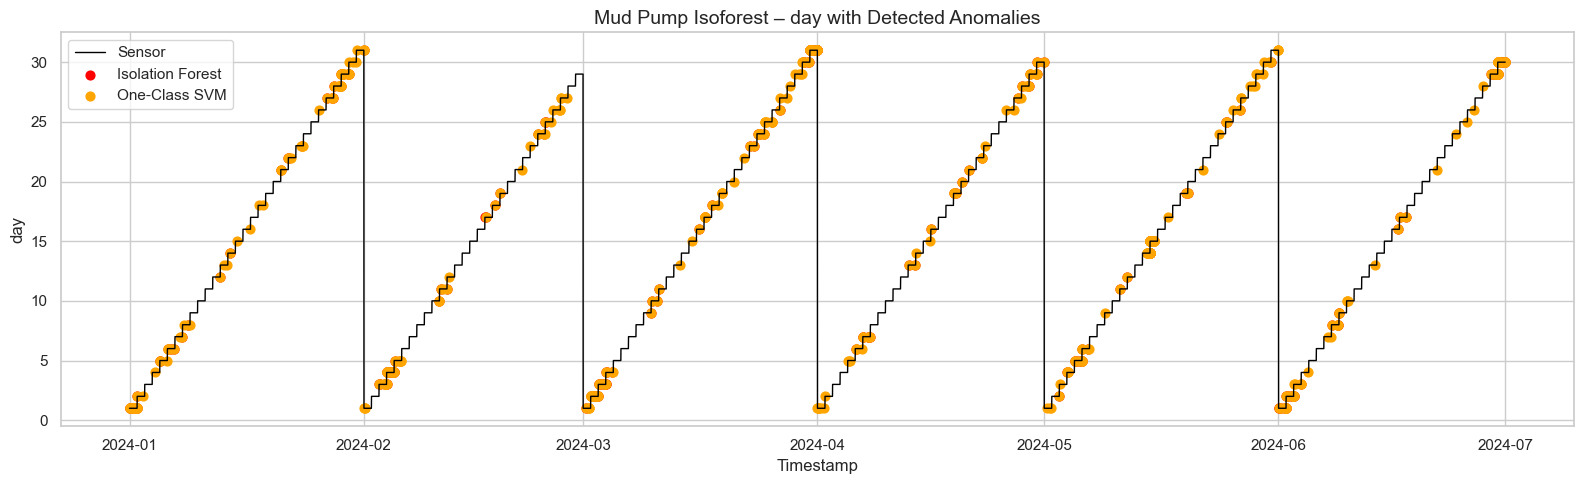

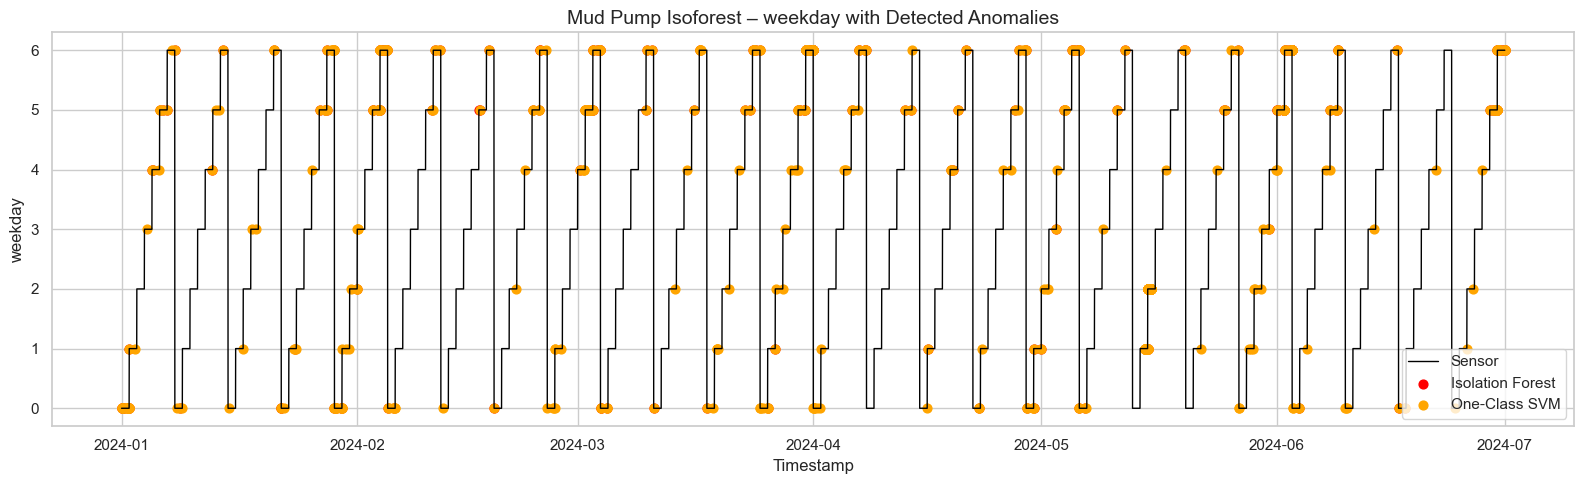

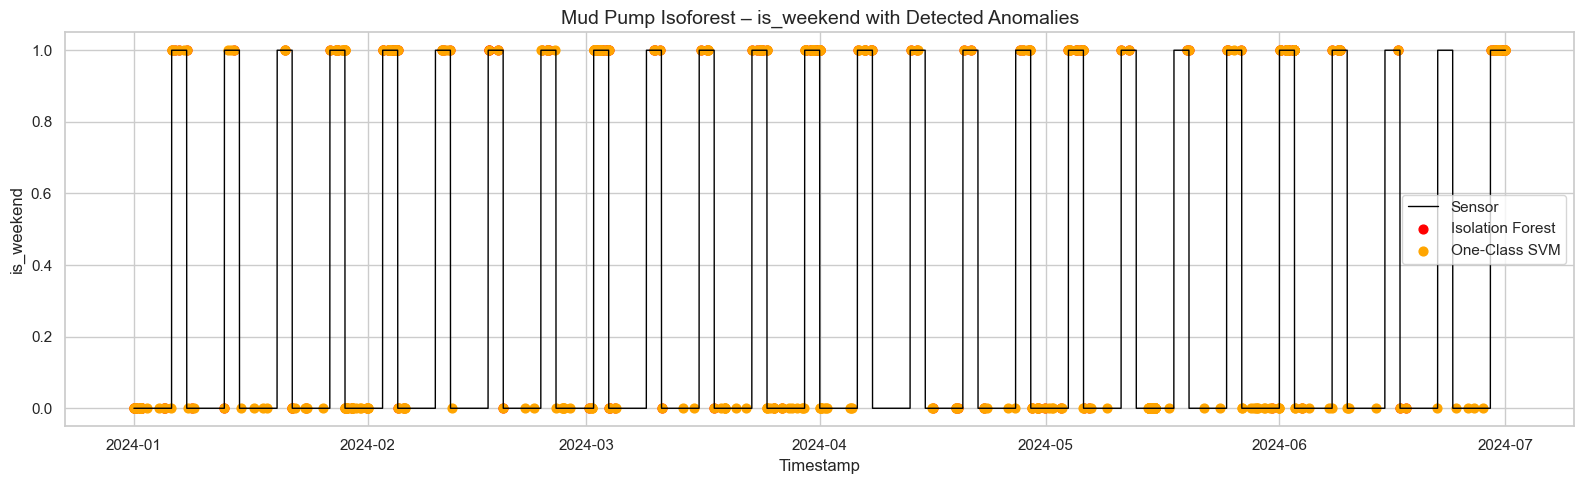

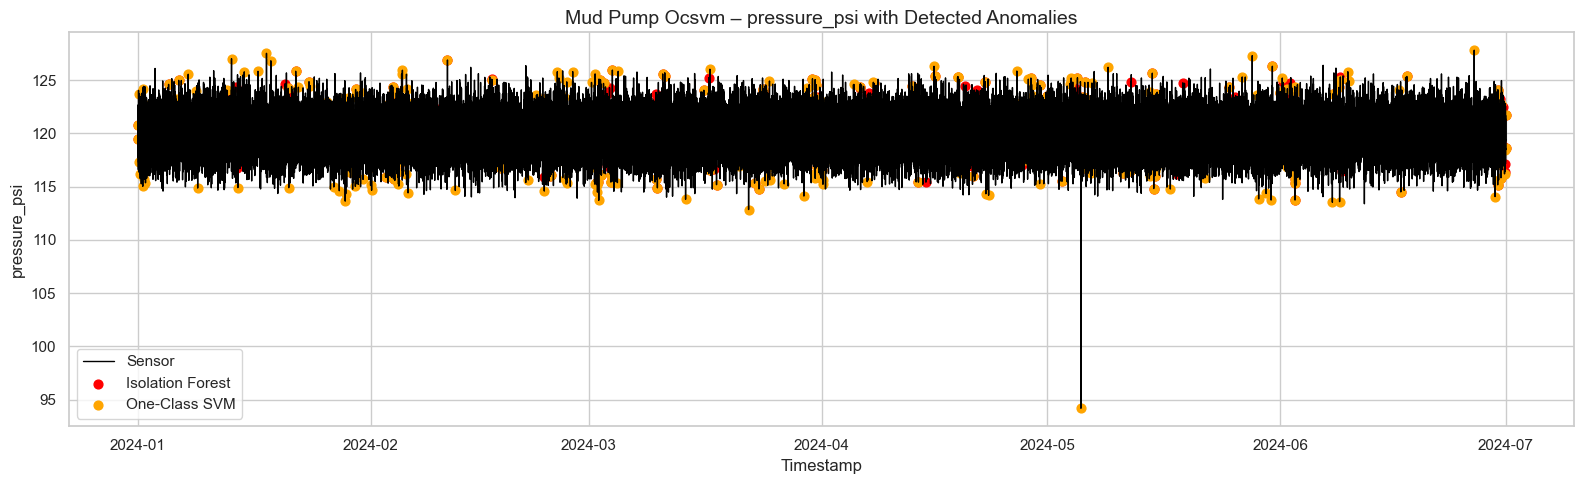

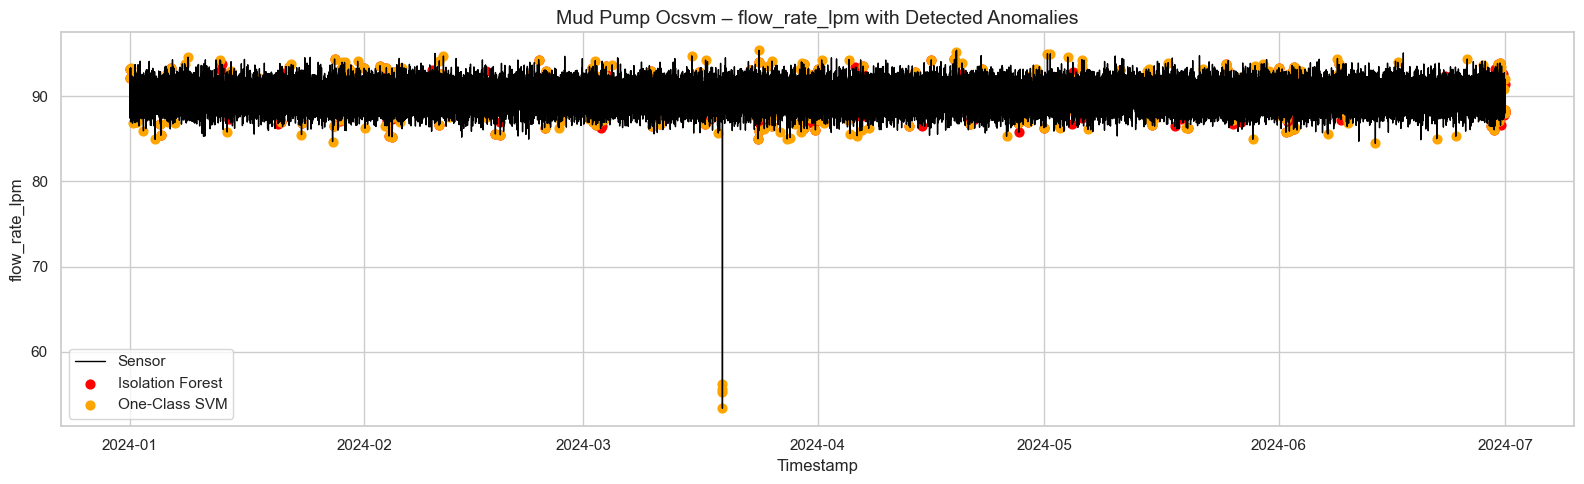

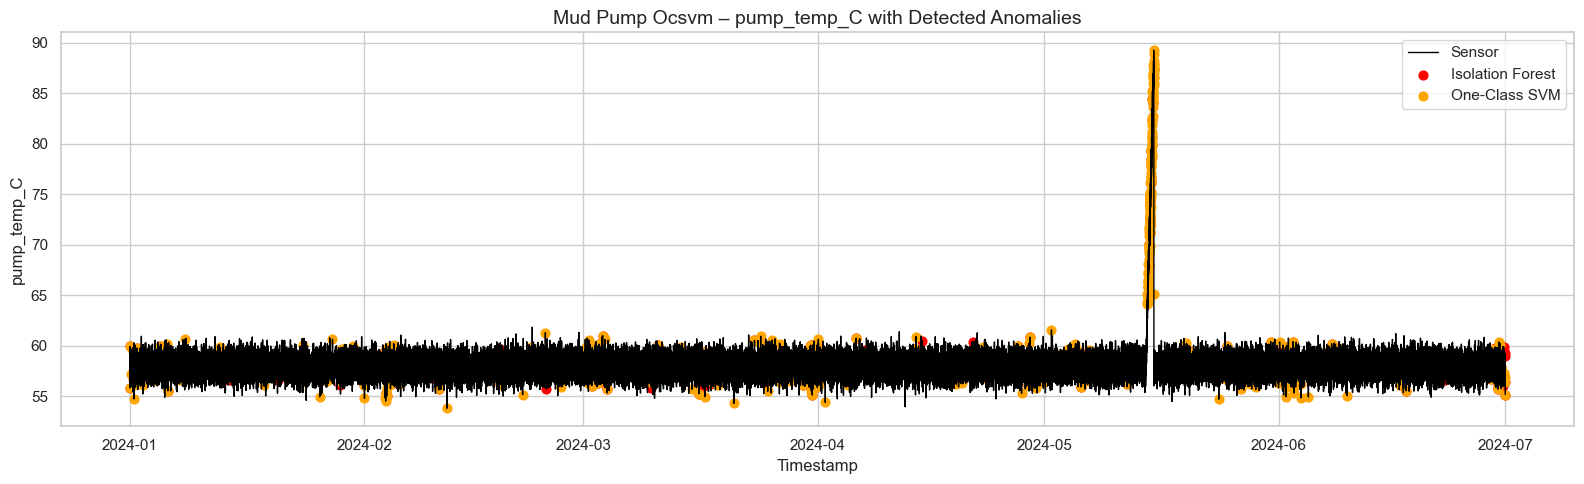

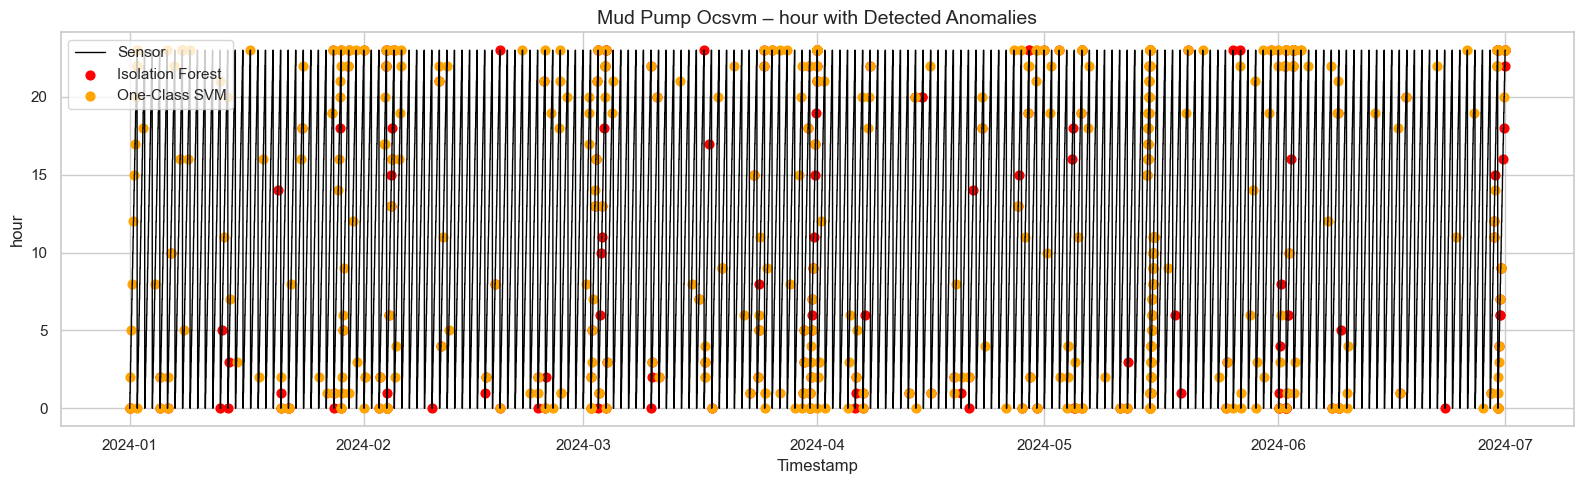

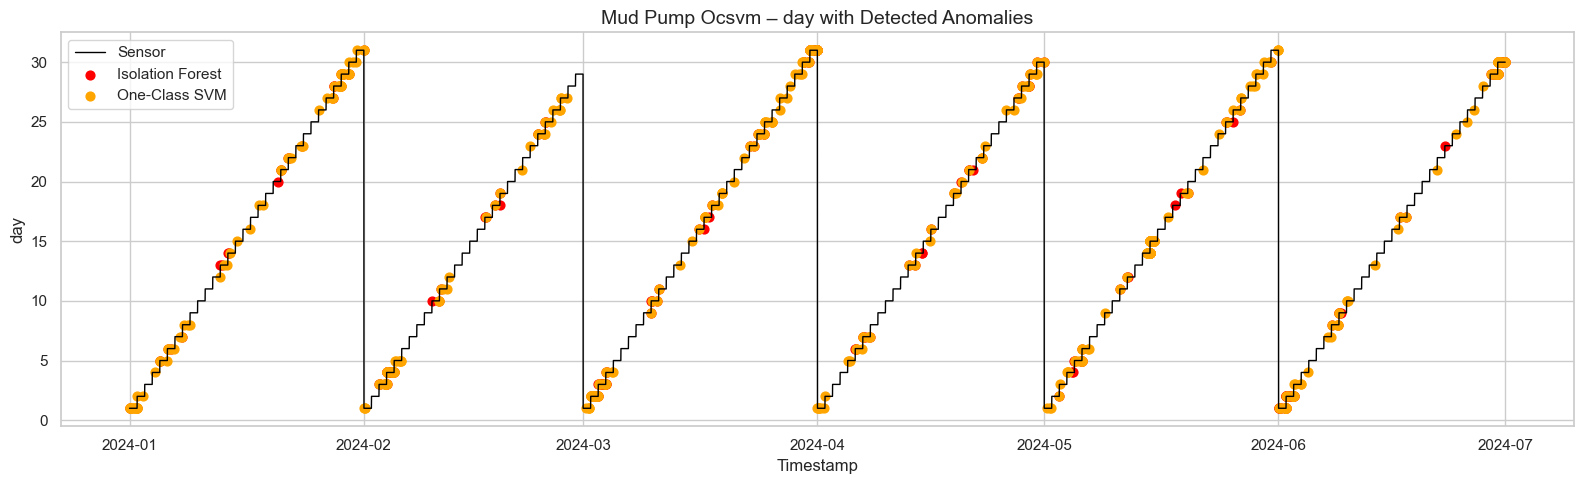

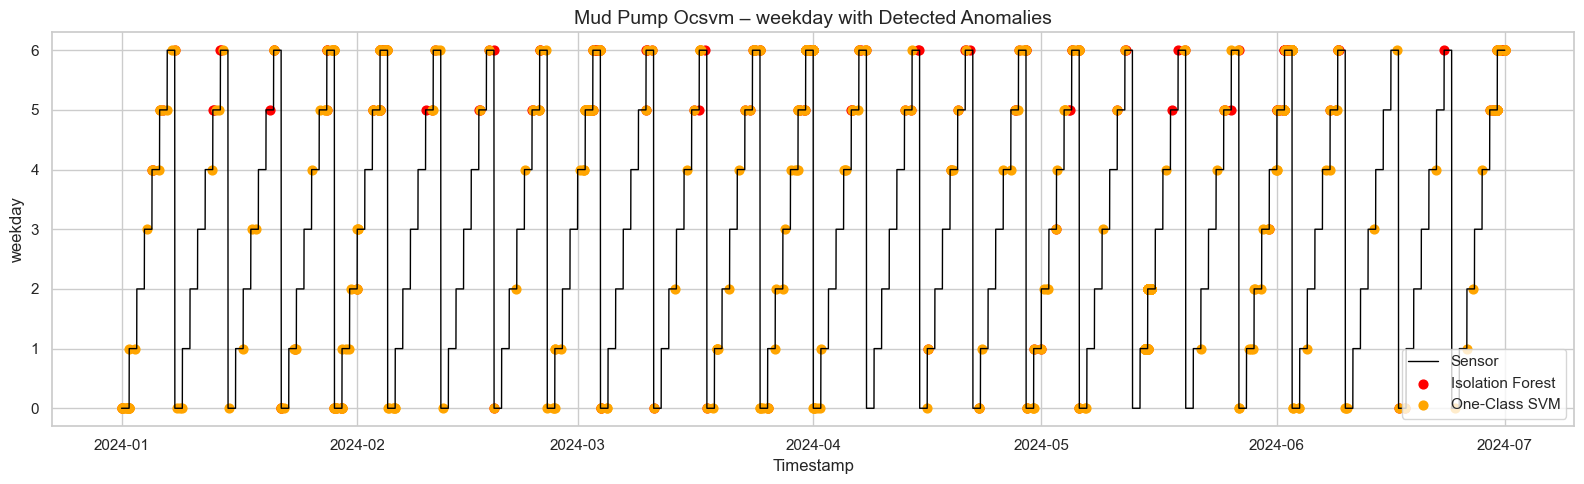

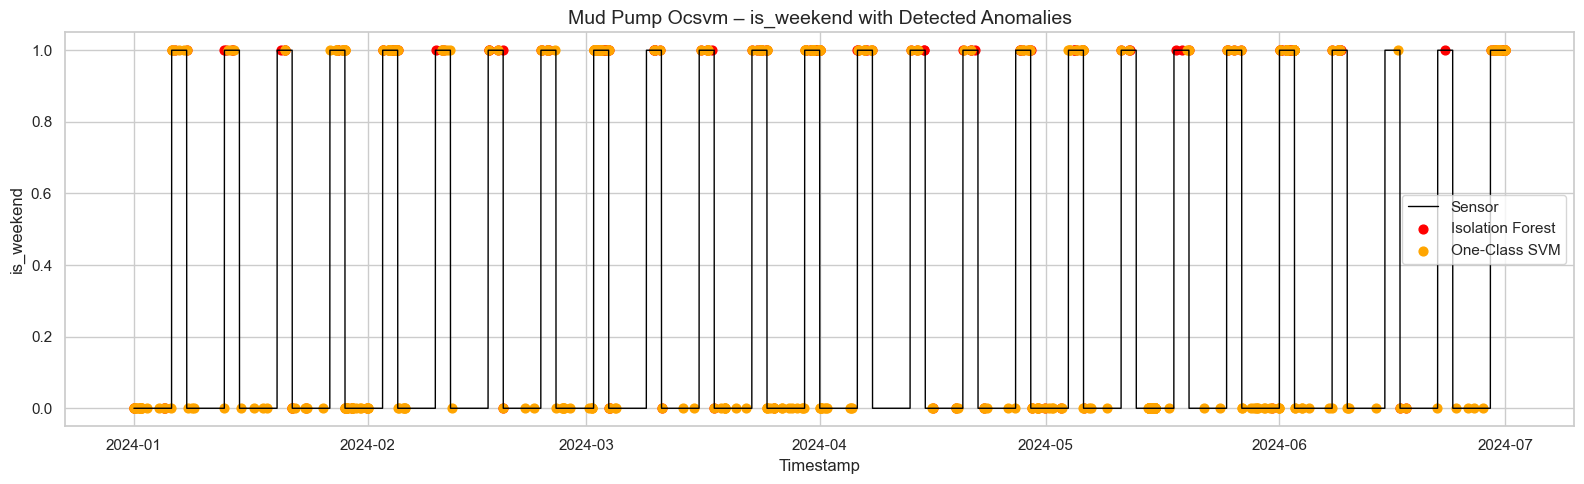

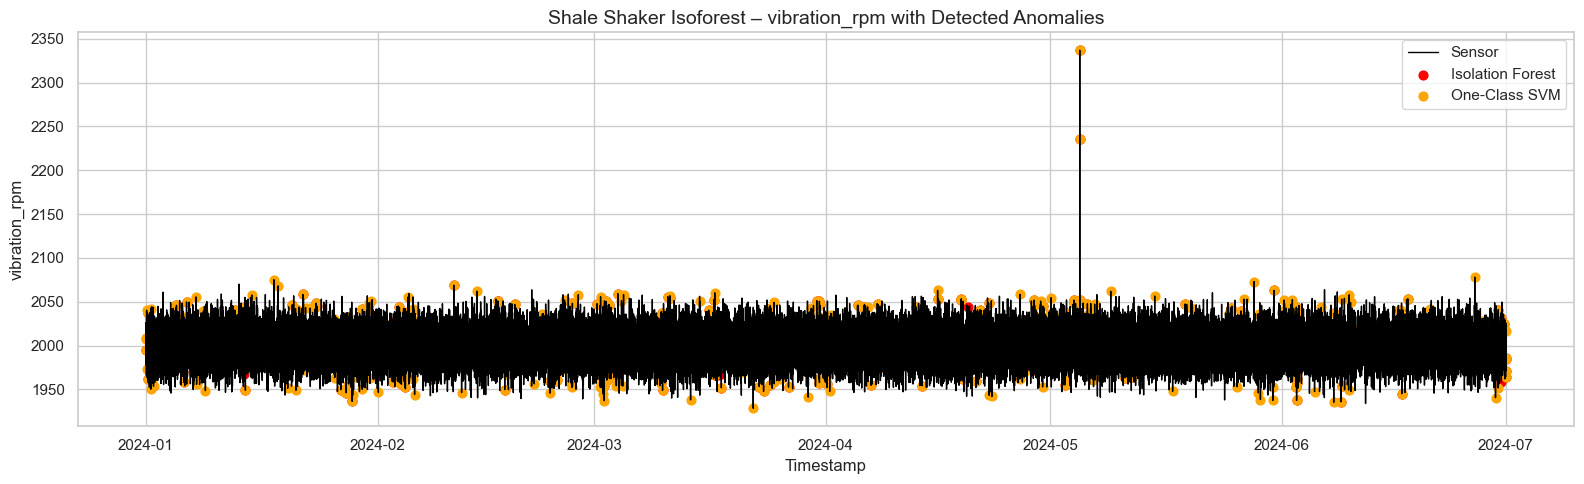

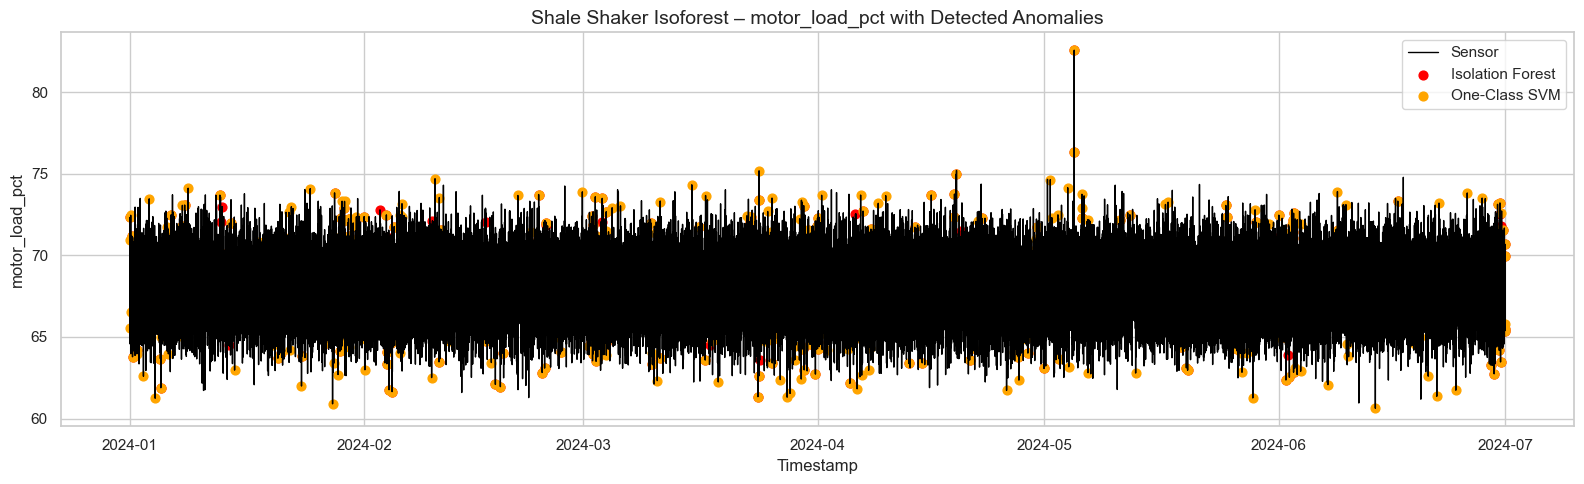

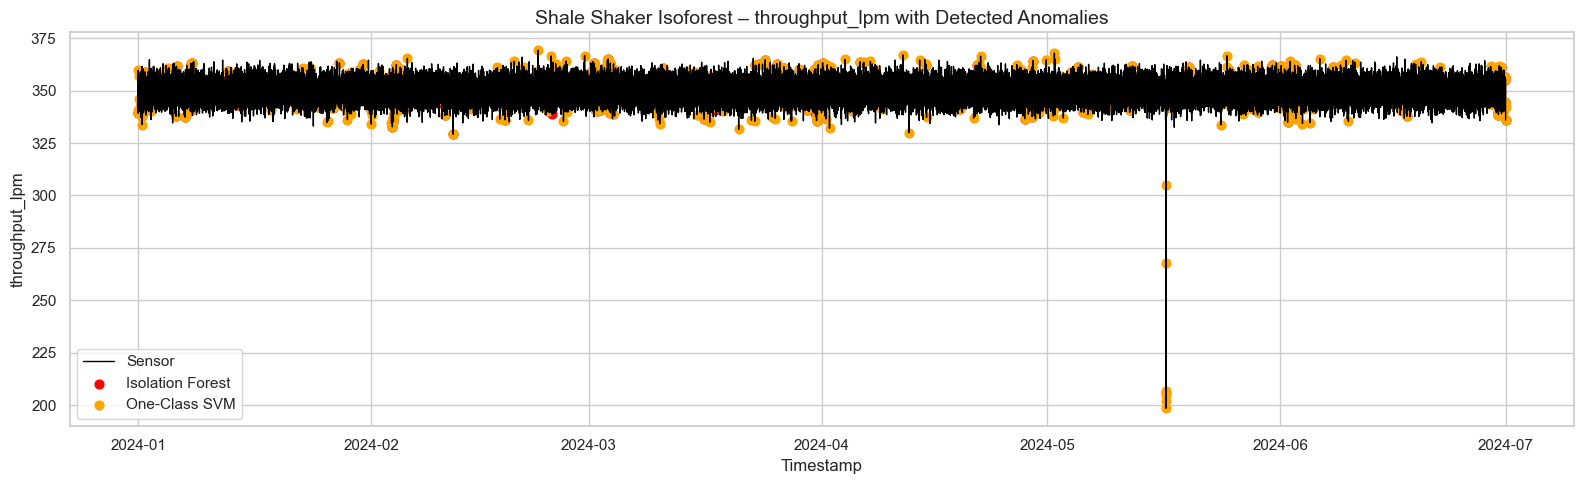

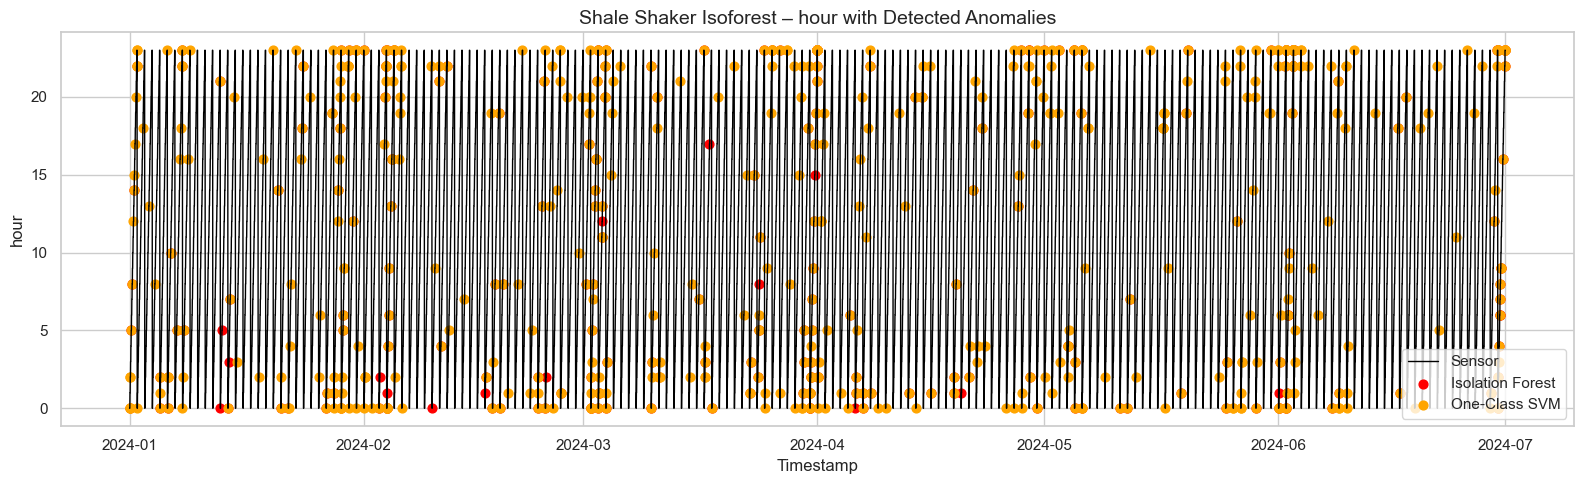

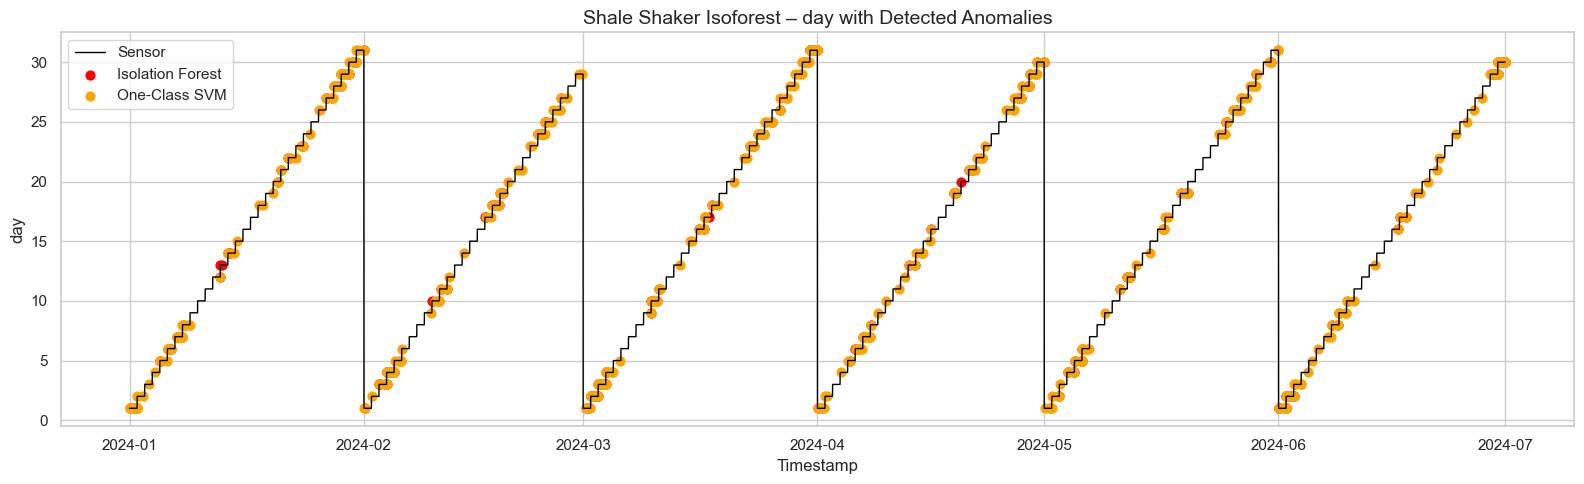

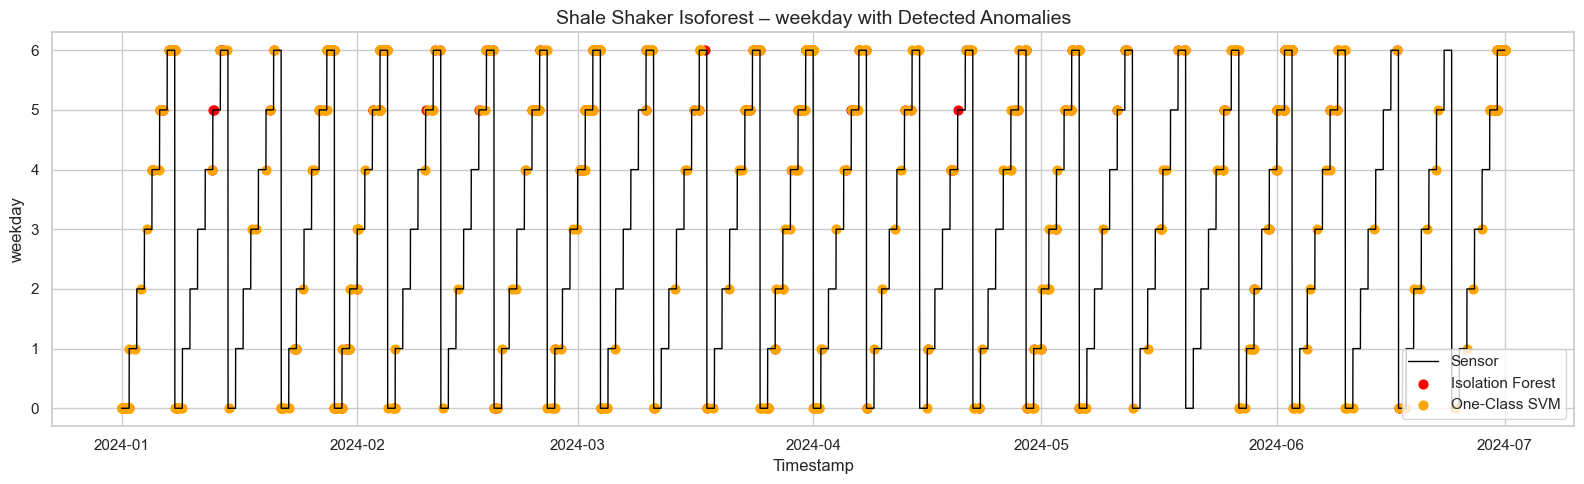

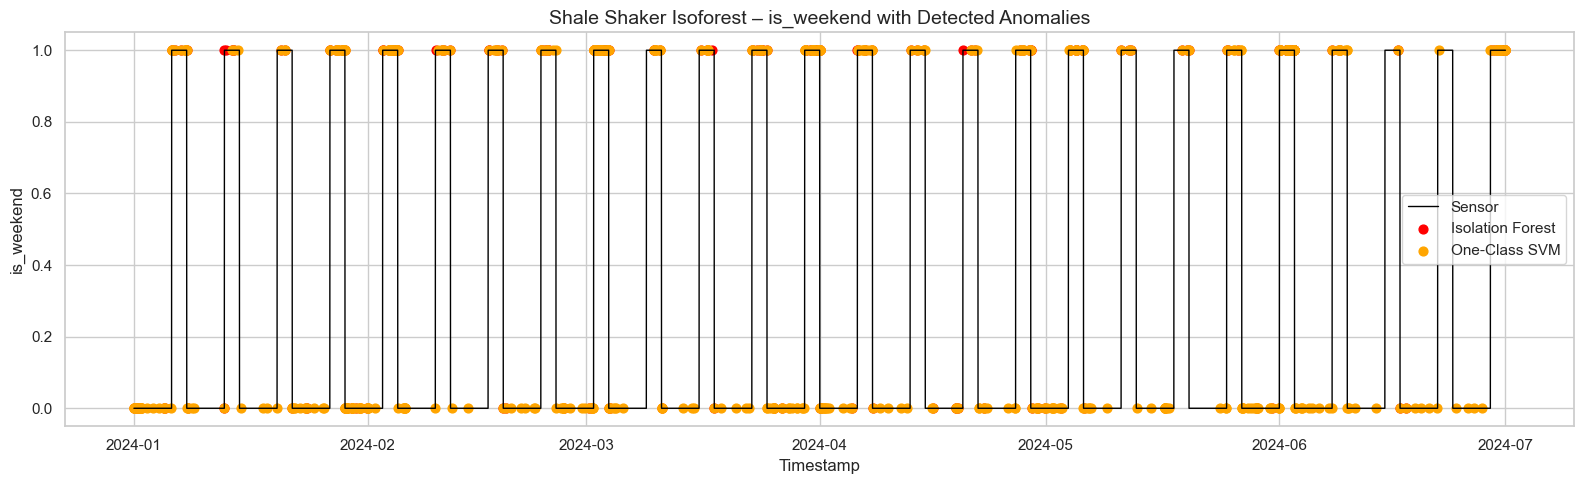

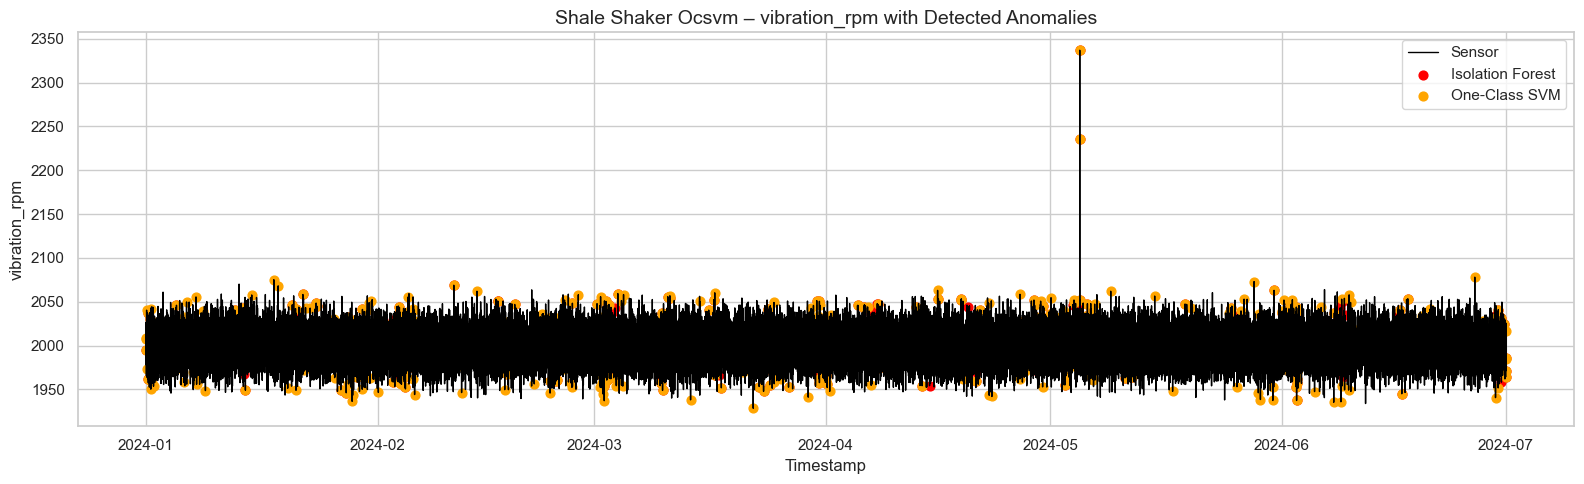

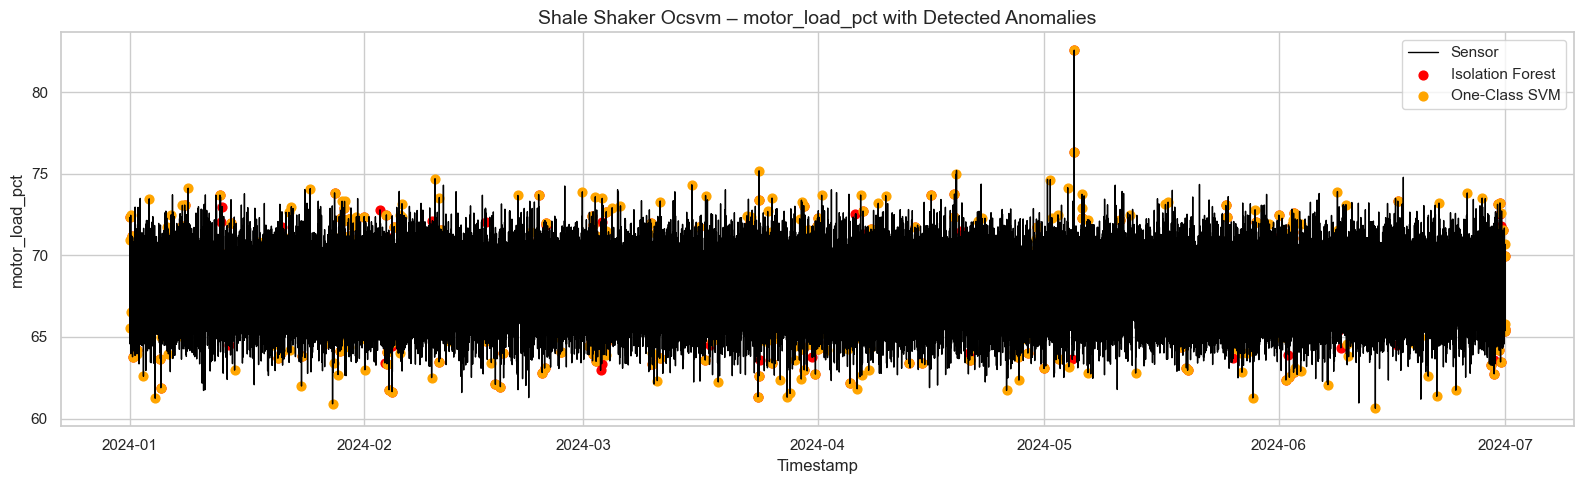

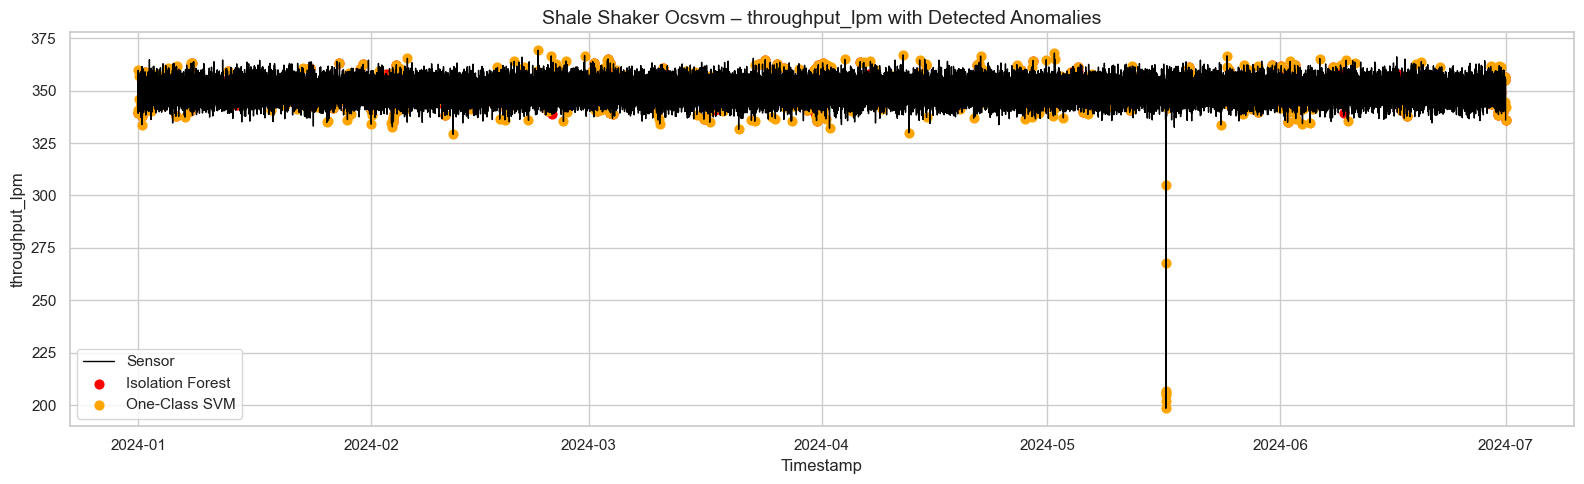

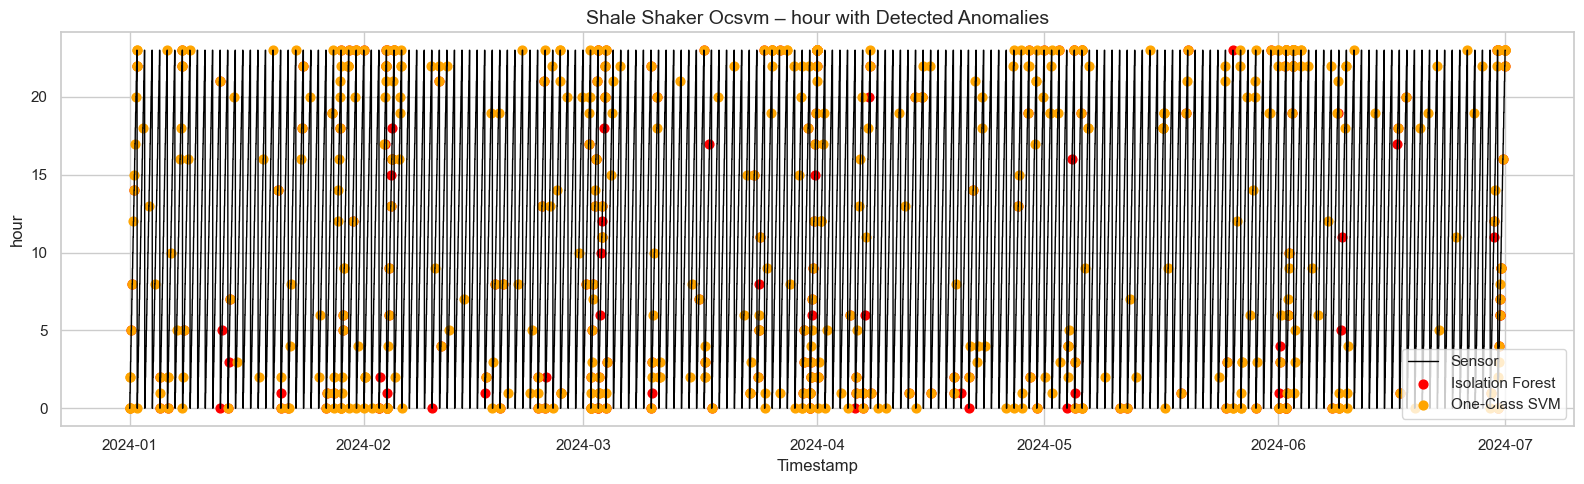

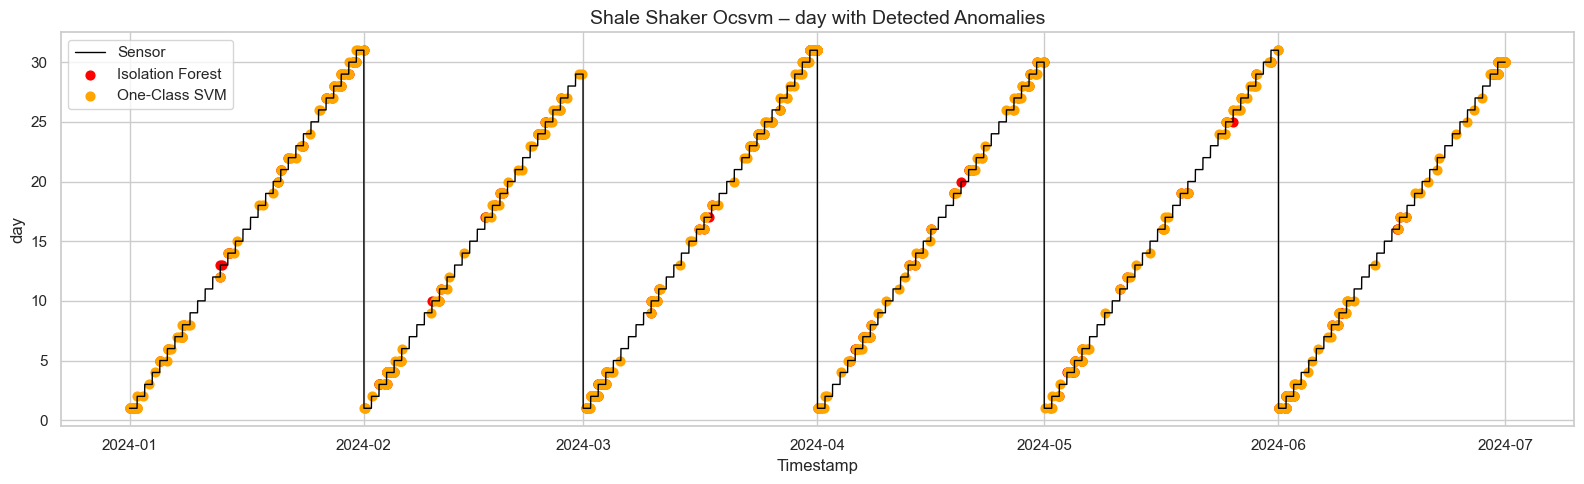

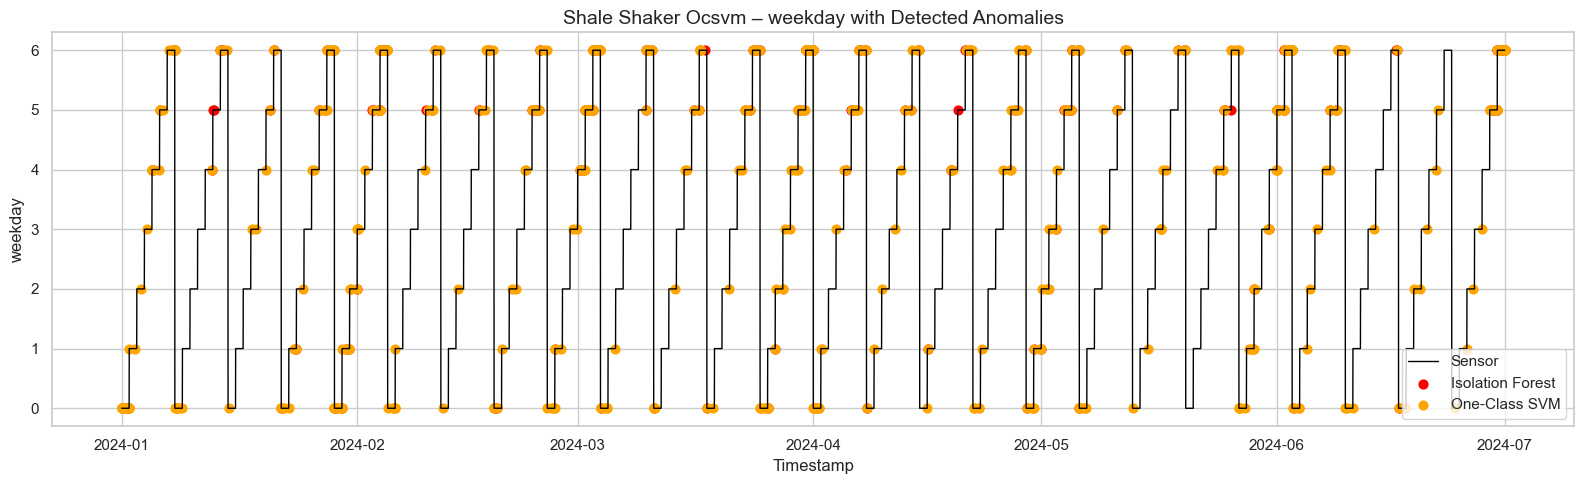

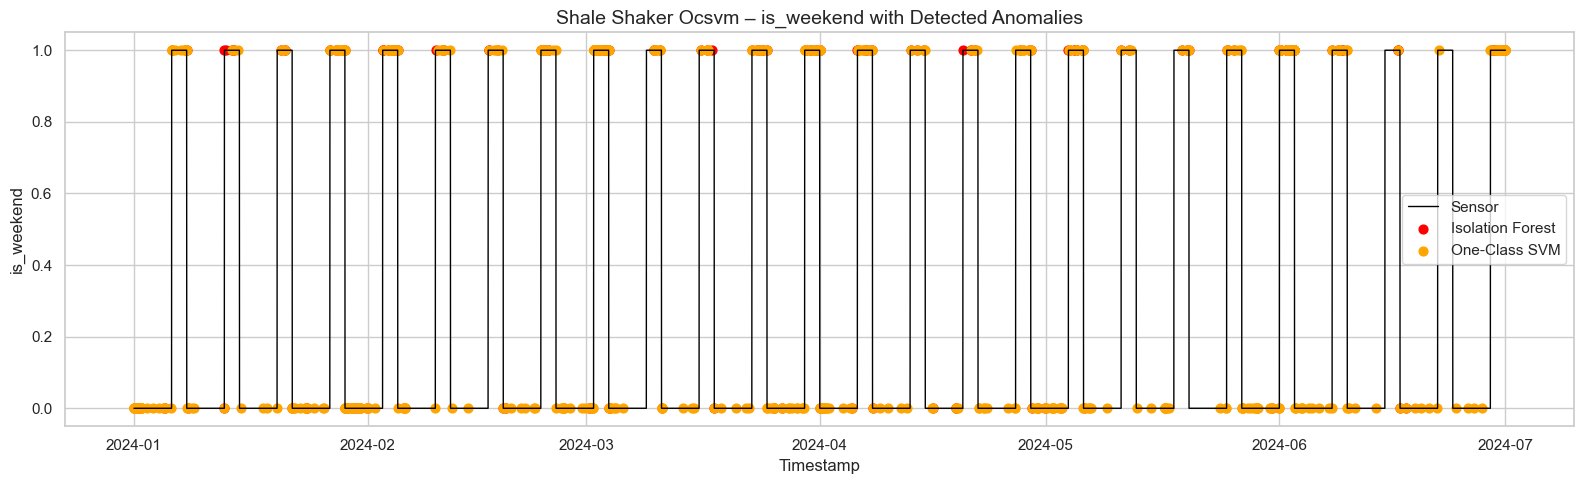

In [5]:
# Customize plot appearance
def plot_anomalies_all_models(df, sensor_col, title):
    plt.figure(figsize=(16, 5))
    plt.plot(df["timestamp"], df[sensor_col], label="Sensor", color="black", linewidth=1)

    if "anomaly_iforest" in df.columns:
        plt.scatter(df.loc[df["anomaly_iforest"] == 1, "timestamp"],
                    df.loc[df["anomaly_iforest"] == 1, sensor_col],
                    color="red", label="Isolation Forest", s=40)
    if "anomaly_ocsvm" in df.columns:
        plt.scatter(df.loc[df["anomaly_ocsvm"] == 1, "timestamp"],
                    df.loc[df["anomaly_ocsvm"] == 1, sensor_col],
                    color="orange", label="One-Class SVM", s=40)
    if "anomaly_lstm" in df.columns:
        plt.scatter(df.loc[df["anomaly_lstm"] == 1, "timestamp"],
                    df.loc[df["anomaly_lstm"] == 1, sensor_col],
                    color="green", label="LSTM Autoencoder", s=40)

    plt.title(title, fontsize=14)
    plt.xlabel("Timestamp")
    plt.ylabel(sensor_col)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Load anomaly-annotated files
anomaly_dir = Path("anomaly_outputs")
csv_files = list(anomaly_dir.glob("*.csv"))

# Equipment-wise plotting
for file in csv_files:
    df = pd.read_csv(file, parse_dates=["timestamp"])
    sensor_cols = df.select_dtypes("number").columns.drop(
        ["anomaly_iforest", "anomaly_ocsvm", "anomaly_lstm", "recon_error"], errors="ignore"
    )
    
    equipment = file.stem.replace("_", " ").title()
    
    for sensor in sensor_cols:
        plot_title = f"{equipment} – {sensor} with Detected Anomalies"
        plot_anomalies_all_models(df, sensor_col=sensor, title=plot_title)
